In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tnrange
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import copy
from IPython import display
import time
import sys
import japanize_matplotlib
import networkx as nx
import matplotlib
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
fpath = "../input/Osaka.ttc"
font_prop = matplotlib.font_manager.FontProperties(fname=fpath)
import japanize_matplotlib
import networkx as nx
from wordcloud import WordCloud, STOPWORDS
import glob
import ast
import MeCab
import re
import swifter
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import datetime
import scipy as sp
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannot import add_stat_annotation
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

In [2]:

from logging import getLogger, StreamHandler, DEBUG, INFO, FileHandler, Formatter
logger = getLogger(__name__)
sthandler = StreamHandler()
sthandler.setLevel(DEBUG)

filehandler = FileHandler("activity_en.log")
filehandler.setLevel(DEBUG)

formatter = Formatter('%(asctime)s:%(lineno)d:%(levelname)s:%(message)s')
filehandler.setFormatter(formatter)
sthandler.setFormatter(formatter)

logger.addHandler(sthandler)
logger.addHandler(filehandler)
logger.setLevel(DEBUG)
logger.propagate = False

logger.debug('hello')  

2022-07-29 05:35:33,165:18:DEBUG:hello


In [3]:
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 
stopwords = list(nltk_stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [4]:
stopwords += STOPWORDS #stopwords
stopwords += ["https", "http", "www", "com", "https://", "http://"] #URL
stopwords = set(stopwords)

## exceptions
regex_str = "%s|%s|%s" % (
    "(.+)\\1{2,}",                 
    "^([0-9]{1,4}[年|月|日]){1,3}$",   
    "^[a-zA-Zあ-んア-ン!-~︰-＠]{1,2}$",   
)
regex = re.compile(regex_str)

def make_corpus(text):
    
    text = text.lower() # lower
    text = text.replace('\n', '') # remove newliner
    text = text.replace('\t', '') # remove tab
    
    text = re.sub('https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # remove url
    text = [i.strip(".|`|\"|,|:|;|-|?|’|‘|#|@|–") for i in text.split(' ') ] # remove unnecesarry tags
    text = [i for i in text if i != ""]
    text = " ".join(text)
    
    words = []
    for word, pos in nltk.pos_tag(nltk.word_tokenize(text)):
        if pos.startswith("NN"): # select noun, verb, adjective
            word = lemmatizer.lemmatize(word) # lemmatize
        else:
            continue
        if regex.search(word): # remove misc words
            continue
        if len(word) <= 2: # remove less than 2 char
            continue
        if word in stopwords: # stopwords
            continue
        words.append(word)
        
    return words

# Clustering

In [12]:
# Tweets and RTs containing words related to covid-19 vaccine 
# Only ids are provided in this repository following the Twitter policy.  (df_vaccine_all_en_ids.csv)
# You have to make dataset from the ids.
with open('../../notebooks/tmp_output/df_vaccine_all_en.pickle', mode='rb') as f:
    tmp_df = pickle.load(f)

In [13]:
# pd.Series(tmp_df.index, name="tweet id").to_csv("df_vaccine_all_en_ids.csv")

In [14]:
tmp_df.shape

(8579728, 26)

### endorsement network

In [163]:
tmp_pairs = [tuple(i) for i in tmp_df.loc[:, ["user_screen_name", "retweeted_status_screen_name"]].values]
tmp_pairs = tmp_pairs + [tuple([i[1], i[0]]) for i in tmp_pairs]
tmp_valuecounts = pd.Series(tmp_pairs).value_counts()

# RT count >= 2
tmp_tmp_pairs = tmp_valuecounts[tmp_valuecounts > 1].index
tmp_tmp_pairs  = set(tmp_tmp_pairs)

unique_pair = [tuple(i) for i in tmp_df.loc[:, ["user_screen_name", "retweeted_status_screen_name"]].values]
unique_pair = set(pd.Series(unique_pair)[pd.Series(unique_pair).isin(tmp_tmp_pairs)].values)

len(unique_pair)

515673

In [19]:
# making network
G = nx.Graph()
G.add_edges_from(unique_pair)
G1 = nx.k_core(G,k=3)
len(G1.nodes())

47135


In [21]:
# nx.write_gexf(G1.to_undirected(), "vaccine_all_1_en.gexf")

### Louvain clustering

In [22]:
#### Conduct clustering in Gephi

# Labeling Clusters

In [21]:
# results clustering in gephi
tmp_tmp_df = pd.read_csv("../../notebooks/RT_vaccine_all_1_en4.csv")

In [29]:
G1 = nx.read_gexf("../../notebooks/vaccine_all_1_en.gexf")

In [23]:
tmp_tmp_df 

,Id,Label,timeset,modularity_class
0,AKimCampbell,AKimCampbell,NaN,33
1,Anan62712520,Anan62712520,NaN,24
2,Kuhlchic,Kuhlchic,NaN,22
3,Truthor67094221,Truthor67094221,NaN,20
4,acoyne,acoyne,NaN,28
...,...,...,...,...
47130,janbear105,janbear105,NaN,28
47131,DianeTierney4,DianeTierney4,NaN,22
47132,JoeyGomezSantos,JoeyGomezSantos,NaN,22
47133,brianypaul,brianypaul,NaN,22


In [24]:
attrs = tmp_tmp_df.set_index("Id")[["modularity_class"]].T.to_dict()#{0: {"attr1": 20, "attr2": "nothing"}, 1: {"attr2": 3}}
nx.set_node_attributes(G1, attrs)

In [25]:
# from the result of gephi
selected_clusters = [22, 20, 24, 31, 13, 25, 33, 23]

In [26]:
tmp_tmp_df["modularity_class"] = tmp_tmp_df["modularity_class"].replace(13, "Pro_Vax")
tmp_tmp_df["modularity_class"] = tmp_tmp_df["modularity_class"].replace(22, "Left")
tmp_tmp_df["modularity_class"] = tmp_tmp_df["modularity_class"].replace(20, "Anti-Vax")
tmp_tmp_df["modularity_class"] = tmp_tmp_df["modularity_class"].replace(24, "Right")
tmp_tmp_df["modularity_class"] = tmp_tmp_df["modularity_class"].replace(31, "Neutral")
tmp_tmp_df["modularity_class"] = tmp_tmp_df["modularity_class"].replace(25, "Neutral")
tmp_tmp_df["modularity_class"] = tmp_tmp_df["modularity_class"].replace(33, "Neutral")

In [27]:
selected_clusters = ["Pro_Vax", "Left", "Anti-Vax", "Right", "Neutral"]

In [31]:
# users
for c, cluster in enumerate(selected_clusters):
    print(cluster)
    tmp_cluster = tmp_tmp_df[tmp_tmp_df["modularity_class"] == cluster]
    subG = G1.subgraph(tmp_cluster["Label"].values)
    display.display(pd.Series(dict(subG.degree())).sort_values(ascending=False)[:10])
    print(len(tmp_cluster)/ len(tmp_tmp_df))
    print("===="*20)

Pro_Vax


HelenBranswell     656
EricTopol          356
megtirrell         345
PeterHotez         341
florian_krammer    320
carlzimmer         316
TheLancet          260
NYTHealth          237
NYTScience         226
nature             208
dtype: int64

0.09165163890951522
Left


DrEricDing        2865
kylegriffin1      1588
atrupar           1069
funder            1036
DrDenaGrayson      889
eugenegu           687
MSNBC              685
MollyJongFast      677
Laurie_Garrett     653
JoeBiden           623
dtype: int64

0.1631271878646441
Anti-Vax


uTobian         1676
LotusOak2       1398
HighWireTalk    1207
Jimcorrsays      804
ChildrensHD      796
sallyKP          738
BusyDrT          699
davidkurten      685
Rectitude20      680
o_rips           656
dtype: int64

0.12232947915561684
Right


WhiteHouse         1658
RealCandaceO       1328
Thomas1774Paine    1203
Mike_Pence          649
TrumpWarRoom        618
johncardillo        597
jsolomonReports     593
Inevitable_ET       578
Jordan_Sather_      572
gatewaypundit       525
dtype: int64

0.12175665641243237
Neutral


Reuters           3163
nytimes           2119
CNN               1984
SkyNews           1431
spectatorindex    1386
AP                1108
ABC                989
washingtonpost     836
cnni               780
thehill            750
dtype: int64

0.24849899225628513


In [32]:
# RT
for c, cluster in enumerate(selected_clusters):
    print(cluster)
    tmp_cluster = tmp_tmp_df[tmp_tmp_df["modularity_class"] == cluster]
    tmptmptmp_df = tmp_df[
        tmp_df["user_screen_name"].isin(set(tmp_cluster["Label"])) & tmp_df["retweeted_status_screen_name"].isin(set(tmp_cluster["Label"]))
    ]
    
    display.display(tmptmptmp_df["text"].value_counts()[:10])
    print("======="*30)

Pro_Vax


rt @nature: more than 90 vaccines are being developed against sars-cov-2 across the world. at least six groups have begun injecting formula…        350
rt @florian_krammer: 1) sars-cov-2 vaccines - i promised a tweetorial and here we go. this is going to be long and nerdy. but i'll make sur…        339
rt @thelancet: new—uk’s #covid19 vaccine is safe and induces an immune reaction, according to preliminary results  h…                               237
rt @trvrb: with #covid19 vaccine efficacy of ~95%, i'm looking forward to vaccine distribution in 2021 bringing the pandemic under control.…        231
rt @nataliexdean: why don't we have a vaccine for sars? mers? hiv? these viruses have been around longer than sars-cov-2. a mini-thread to…         226
rt @virusesimmunity: how does the immune system work? will there be #covid19 vaccines? @biorender &amp; i put together ‘immunology 101 tweetori…    182
rt @florian_krammer: i am about to hire a postdoc from spain who is specialized in vacci

Left


rt @kamalaharris: the biden-harris plan to get coronavirus under control includes: free covid-19 testing, treatment, and vaccines for every…    1923
rt @newyorkstateag: any attempt by donald trump to deny new york access to a lifesaving #covid19 vaccine will be met with a lawsuit, plain…     1914
rt @joebiden: the coronavirus test should be made widely available and free.the coronavirus vaccine, when ready, should be made widely av…      1496
rt @tribelaw: expect trump to claim in mid to late october that a great coronavirus vaccine has been developed and will soon be universally…    1454
rt @senschumer: today, i am announcing a major push to make the coronavirus vaccine fully covered by medicare.because seniors who will ne…      1446
rt @craig_a_spencer: a vaccine won’t help any of the patients with covid19 in my er right now. it won’t help those that’ll come tomorrow ei…    1331
rt @senwarren: it is a huge conflict of interest for the white house’s new vaccine czar to own $10 million

Anti-Vax


rt @lotusoak2: bill gates' plan to "save the world" by rolling out a potentially mandatory vaccine for the #coronavirus - &amp; suggesting nobo…    946
rt @lotusoak2: why is there no vaccine against the common cold, sars, mers, or hiv? why is the #flushot worse than doing nothing at all?…           831
rt @lotusoak2: nih/ nci scientist whistleblower dr judy mikovits says nih tony fauci knows vaccines cause autism, transmissible cancers (&amp;…     620
rt @utobian: when the 150+ coronavirus vaccines begin to hit the market this fall:all vaccine deaths will be blamed on the virus.all vac…           571
rt @rectitude20: 1. i will not take a covid19 vaccine.2. i will not take any of today’s vaccines.3. there is not one vaccine on the marke…          506
rt @utobian: 100% failure rate in oxford university coronavirus vaccine trial... moves on to human trials anyway. that's what happens whe…          493
rt @highwiretalk: breaking: loudly chanting their opposition to face masks and vaccines,

Right


rt @thomas1774paine: icymi - exclusive: robert f. kennedy jr. drops new bombshell — bill gates’ coronavirus vaccine will pay out billions i…    1948
rt @realcandaceo: forget hydroxychloroquine or bill gates’ vaccines! turns out the real cure to coronavirus is a media-manufactured race wa…    1775
rt @realcandaceo: this is your daily reminder that under no circumstances will i be getting any #coronavirus vaccine that becomes available…    1716
rt @billcassidy: as a doctor who ran vaccine programs to decrease the spread of disease, @realdonaldtrump is doing what’s necessary to prot…    1691
rt @charliekirk11: breaking:a new vaccine is in the works for the china corona virusthe first participant in the clinical trial will re…        1424
rt @education4libs: like or rt if you will not be taking a coronavirus vaccine.                                                                 1316
rt @ryanafournier: fact:under president trump, the process of getting a coronavirus vaccine into testing h

Neutral


rt @bbcbreaking: coronavirus vaccine developed by oxford university appears safe and trains the immune system, key early trials show            604
rt @cnn: dolly parton's $1 million donation to coronavirus research at vanderbilt university helped fund moderna's vaccine                      486
rt @cnn: coronavirus lockdowns across the globe should not be completely lifted until a vaccine for the disease is found, according to a st…    479
rt @petemuntean: breaking - ups and fedex trucks carrying the first u.s. shipment of coronavirus vaccine have left pfizer’s facility near k…    467
rt @uniofoxford: today marks an important milestone in the fight against #covid19. interim data show the #oxfordvaccine is 70.4% effective,…    457
rt @ap: breaking: the first vaccine tested in the u.s. for the coronavirus boosted volunteers' immune systems as hoped, researchers report.…    451
rt @nytimes: breaking news: the fda authorized pfizer’s coronavirus vaccine for emergency use, clearing the way 

In [33]:
tmp_stop_words = ["corona", "virus", "coronavirus","covid", "covid-19", "covid19", "vaccine", "vax", "vaccination"]#, "新型", "コロナウイルス", "コロナウィルス", "新型コロナ", "新型コロナウィルス", "新型コロナウイルス"]
tmp_stop_words += list(nltk_stopwords.words('english'))
tmp_stop_words += STOPWORDS
tmp_stop_words = list(set(tmp_stop_words))
tmp_stop_words2 = ["amp"]
tmp_stop_words += tmp_stop_words2

In [34]:
def my_tf_color_func(dictionary):
    def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(0, 100%%, %d%%)" % (50 * ((dictionary[word] - min(dictionary.values())) / (max(dictionary.values()) - min(dictionary.values()))))
    return my_tf_color_func_inner

In [35]:
tmp_list = [0] * len(selected_clusters)
for c, cluster in enumerate(selected_clusters):
    print(cluster)
    tmp_cluster = tmp_tmp_df[tmp_tmp_df["modularity_class"] == cluster]
    tmptmptmp_df = tmp_df[
        tmp_df["user_screen_name"].isin(set(tmp_cluster["Label"])) & tmp_df["retweeted_status_screen_name"].isin(set(tmp_cluster["Label"]))
    ]
    
    tmp_count = tmptmptmp_df["nouns"].map(set).map(tuple).value_counts()[:50]
    #tmp_all_words = [[i]* int(np.log(tmp_count[i]+1)*10) for i in tmp_count.index]
    tmp_all_words = [[i]* int(tmp_count[i]/20) for i in tmp_count.index]
    tmp_all_words = [i for sub in tmp_all_words for i in sub]
    tmp_all_words = [i for sub in tmp_all_words for i in sub]
    #tmp_all_words = [i for i in tmp_all_words if i in list(feature_array)]
    tmp_all_words = list(pd.Series(tmp_all_words)[~pd.Series(tmp_all_words).isin(set(tmp_stop_words + list(tmp_cluster["Label"])))].values)
    text = " ".join(tmp_all_words)
    
    tmp_list[c] = copy.copy(text)
    #tmp_list.append(text)
    
tfidf_vectorizer = TfidfVectorizer(use_idf=True, norm='l2', smooth_idf=True)#, lowercase=False, sublinear_tf=True)
tmp_tfidf = tfidf_vectorizer.fit_transform(tmp_list)

Pro_Vax
Left
Anti-Vax
Right
Neutral


In [36]:
feature_array = np.array(tfidf_vectorizer.get_feature_names())

Pro_Vax


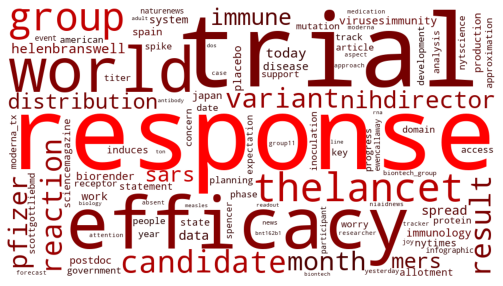

Left


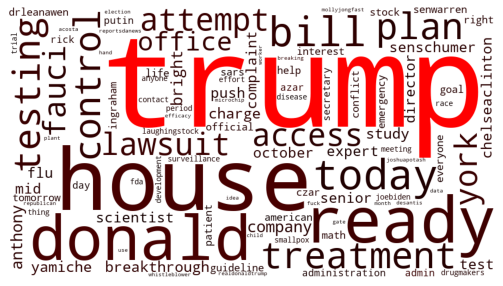

Anti-Vax


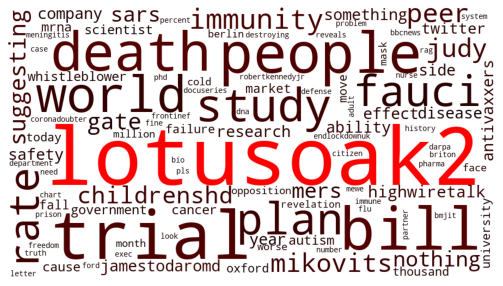

Right


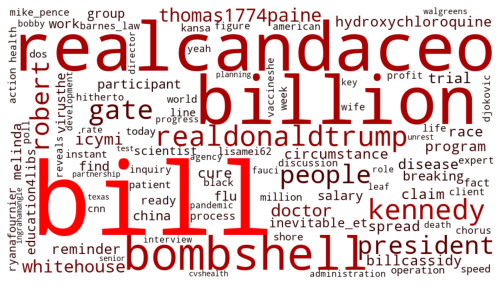

Neutral


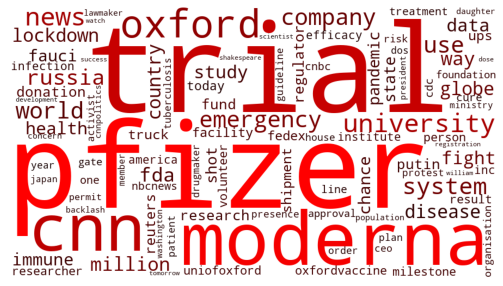

In [37]:
for c, cluster in enumerate(selected_clusters):
    print(cluster)
    tmp_cluster = tmp_tmp_df[tmp_tmp_df["modularity_class"] == cluster]
    tmptmptmp_df = tmp_df[
        tmp_df["user_screen_name"].isin(set(tmp_cluster["Label"])) & tmp_df["retweeted_status_screen_name"].isin(set(tmp_cluster["Label"]))
    ]
    
    #tmp_all_words = [i for sub in tmptmptmp_df["nouns"].map(set).map(tuple).value_counts()[:500].index for i in sub ]
    #tmp_all_words = [i for sub in tmptmptmp_df["nouns"] for i in sub ]
    tmp_count = tmptmptmp_df["nouns"].map(set).map(tuple).value_counts()[:50]
    #tmp_all_words = [[i]* int(np.log(tmp_count[i]+1)*10) for i in tmp_count.index]
    tmp_all_words = [[i]* int(tmp_count[i]/20) for i in tmp_count.index]
    tmp_all_words = [i for sub in tmp_all_words for i in sub]
    tmp_all_words = [i for sub in tmp_all_words for i in sub]
    tmp_all_words = list(pd.Series(tmp_all_words)[pd.Series(tmp_all_words).isin(list(feature_array))].values)#[i for i in tmp_all_words if i in list(feature_array)]
    tmp_all_words = list(pd.Series(tmp_all_words)[~pd.Series(tmp_all_words).isin(set(tmp_stop_words + list(tmp_cluster["Label"])))].values)
    #tmp_all_words = [i for i in tmp_all_words if i not in set(tmp_stop_words + list(tmp_cluster["Label"]))]
    #tmp_counts = np.log(pd.Series(tmp_all_words).value_counts())
    #tmp_all_words = [[i]*int(np.log(tmp_counts[i]+2)*20) for i in tmp_counts.index]
    top_100_words = list(pd.Series(tmp_all_words).value_counts()[:100].index)
    
    text = " ".join([i for i in tmp_all_words if i in top_100_words])#[i for sub in tmp_all_words for i in sub])
    
    
#     tmp_tmp_count = np.log(tmp_count[j].toarray()[0][tfidf_sorting[::-1][:n]])
#     tmp_tmp_count = [i/max(tmp_tmp_count) for i in tmp_tmp_count]
    
    #tfidf_sorting = np.argsort(tmp_tfidf.toarray()[c])[::-1]
    tmp_words = list(feature_array)
    tmptmp_tfidf = list(tmp_tfidf.toarray()[c])
    tmp_dict = dict(zip(tmp_words, tmptmp_tfidf))
    
    
    #fpath = "../input/Osaka.ttc"
    
    wordcloud = WordCloud(
        background_color="white",
        #font_path=fpath, 
        width=900, 
        height=500,
        collocations = False,
        color_func=my_tf_color_func(tmp_dict)
    ).generate(text)

    plt.figure(figsize=(9,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    
#     plt.savefig("figures/wordcloud_en_%s.png"%str(c), format="png", dpi=300, bbox_inches='tight')
    plt.show()


# Stats

### node

In [38]:
for c, cluster in enumerate(selected_clusters):
    print(cluster)
    tmp_cluster = tmp_tmp_df[tmp_tmp_df["modularity_class"] == cluster]
    print("node_num", len(tmp_cluster))

Pro_Vax
node_num 4320
Left
node_num 7689
Anti-Vax
node_num 5766
Right
node_num 5739
Neutral
node_num 11713


In [39]:
import seaborn as sns

## Reply

In [40]:
reply_dict = {}
for c, cluster1 in enumerate(selected_clusters):
    tmp_cluster1 = tmp_tmp_df[tmp_tmp_df["modularity_class"] == cluster1]
    reply_dict[cluster1] = {}
    for cc, cluster2 in enumerate(selected_clusters):
        tmp_cluster2 = tmp_tmp_df[tmp_tmp_df["modularity_class"] == cluster2]
        
        tmp_df_reply = tmp_df[tmp_df["user_screen_name"].isin(tmp_cluster1["Label"]) & tmp_df["in_reply_to_screen_name"].isin(tmp_cluster2["Label"])]
        
        #tmp_df_edges = df_edges[(df_edges["source"].isin(tmp_cluster1["Label"])) & (df_edges["target"].isin(tmp_cluster2["Label"]))]
        #print(len(tmp_df_edges))
        reply_dict[cluster1][cluster2] = len(tmp_df_reply)

In [41]:
print("row:source column:target")
df_reply = pd.DataFrame(reply_dict).T
df_reply

row:source column:target


,Pro_Vax,Left,Anti-Vax,Right,Neutral
Pro_Vax,3862,131,219,65,196
Left,80,1538,19,156,157
Anti-Vax,355,194,4946,601,1406
Right,14,19,57,642,48
Neutral,94,192,59,91,4472


In [42]:
df_reply_ratio = df_reply.divide(df_reply.sum(axis=1), axis=0)
df_reply_ratio

,Pro_Vax,Left,Anti-Vax,Right,Neutral
Pro_Vax,0.863403,0.029287,0.048960,0.014532,0.043818
Left,0.041026,0.788718,0.009744,0.080000,0.080513
Anti-Vax,0.047321,0.025860,0.659291,0.080112,0.187417
Right,0.017949,0.024359,0.073077,0.823077,0.061538
Neutral,0.019152,0.039120,0.012021,0.018541,0.911165


In [43]:
tmptmp_data = []
for c in tqdm(selected_clusters):
    tmp_cluster1 = tmp_tmp_df[tmp_tmp_df["modularity_class"] == c]
    
    tmptmp_data.append(
        [len(tmp_cluster1), 
         tmp_df[tmp_df["user_screen_name"].isin(tmp_cluster1["Label"])].shape[0],
         tmp_df[tmp_df["user_screen_name"].isin(tmp_cluster1["Label"])].shape[0] / len(tmp_cluster1),
         tmp_df[(tmp_df["user_screen_name"].isin(tmp_cluster1["Label"])) & (tmp_df["in_reply_to_screen_name"].notnull())].shape[0],
         100*tmp_df[(tmp_df["user_screen_name"].isin(tmp_cluster1["Label"])) & (tmp_df["in_reply_to_screen_name"].notnull())].shape[0]/ tmp_df[tmp_df["user_screen_name"].isin(tmp_cluster1["Label"])].shape[0],
         tmp_df[tmp_df["in_reply_to_screen_name"].isin(tmp_cluster1["Label"])].shape[0],
         tmp_df[tmp_df["in_reply_to_screen_name"].isin(tmp_cluster1["Label"])].shape[0] / len(tmp_cluster1),
         tmp_df[(tmp_df["user_screen_name"].isin(tmp_cluster1["Label"])) & (tmp_df["retweeted_status_screen_name"].notnull())].shape[0],
         100*tmp_df[(tmp_df["user_screen_name"].isin(tmp_cluster1["Label"])) & (tmp_df["retweeted_status_screen_name"].notnull())].shape[0] / tmp_df[tmp_df["user_screen_name"].isin(tmp_cluster1["Label"])].shape[0],
        ]
    )


  0%|          | 0/5 [00:00<?, ?it/s]

In [44]:
pd.DataFrame(index=selected_clusters,
            columns=["User", "TW", "TW/User", "RP", "RP/TW(%)", "toRP", "toRP/User", "RT", "RT/TW(%)"],
             data=tmptmp_data
            ).loc[:, ["User", "TW", "TW/User", "RP", "RP/TW(%)", "RT", "RT/TW(%)"]]

,User,TW,TW/User,RP,RP/TW(%),RT,RT/TW(%)
Pro_Vax,4320,216130,50.030093,6501,3.007912,165599,76.620090
Left,7689,351436,45.706334,3302,0.939574,319044,90.782959
Anti-Vax,5766,282665,49.022719,14291,5.055808,240648,85.135408
Right,5739,203288,35.422199,1419,0.698024,188925,92.934654
Neutral,11713,544882,46.519423,6800,1.247977,438701,80.513029


In [45]:
print("row:source column:target")
df_reply_ = pd.DataFrame(reply_dict).T
# df_reply = df_reply.rename(columns={2: "U_news", 4:"Pro", 7:"Anti", 9:"U_right", 11:"U_left"}, index={2: "U_news", 4:"Pro", 7:"Anti", 9:"U_right", 11:"U_left"})
# df_reply = df_reply.loc[["Anti", "Pro", "U_news", "U_right", "U_left"], ["Anti", "Pro", "U_news", "U_right", "U_left"]]
df_reply_

row:source column:target


,Pro_Vax,Left,Anti-Vax,Right,Neutral
Pro_Vax,3862,131,219,65,196
Left,80,1538,19,156,157
Anti-Vax,355,194,4946,601,1406
Right,14,19,57,642,48
Neutral,94,192,59,91,4472


In [46]:
dict_inner_inter_reply = {}
for i in selected_clusters:
    dict_inner_inter_reply[i] = {}
    dict_inner_inter_reply[i]["Inner Reply"] = df_reply_.loc[i,i]
    dict_inner_inter_reply[i]["Inter Reply"] = df_reply_.loc[i,[j for j in selected_clusters if j!=i]].sum()
pd.DataFrame(dict_inner_inter_reply).T.divide( pd.DataFrame(dict_inner_inter_reply).T.sum(axis=1), axis=0)

,Inner Reply,Inter Reply
Pro_Vax,0.863403,0.136597
Left,0.788718,0.211282
Anti-Vax,0.659291,0.340709
Right,0.823077,0.176923
Neutral,0.911165,0.088835


In [48]:
for i in selected_clusters:
    print(i)
    tmp_df_inner_inter = pd.DataFrame(dict_inner_inter_reply).T
    
    x2, p, dof, expected = sp.stats.chi2_contingency(
        np.array(
            [
                [tmp_df_inner_inter.loc[i, "Inner Reply"], tmp_df_inner_inter.loc[[j for j in selected_clusters if j != i], "Inner Reply"].sum()],
                [tmp_df_inner_inter.loc[i, "Inter Reply"], tmp_df_inner_inter.loc[[j for j in selected_clusters if j != i], "Inter Reply"].sum()]
            ]
        )
    )




    if p < 0.05:
        print("significant")
    else:
        print("not significant")
    print("chi square %(x2)s" %locals() )
    print("prob %(p)s" %locals() )
    print("dof %(dof)s" %locals() )
    print( expected )

Pro_Vax
significant
chi square 195.47810371733033
prob 2.0261245174609536e-44
dof 1
[[ 3525.85428032 11934.14571968]
 [  947.14571968  3205.85428032]]
Left
not significant
chi square 0.00056584211668929
prob 0.9810221617469509
dof 1
[[ 1537.09274461 13922.90725539]
 [  412.90725539  3740.09274461]]
Anti-Vax
significant
chi square 1209.291798664935
prob 5.833625298584526e-265
dof 1
[[5913.47167695 9546.52832305]
 [1588.52832305 2564.47167695]]
Right
significant
chi square 5.686714081008449
prob 0.017093833410411013
dof 1
[[  614.83709784 14845.16290216]
 [  165.16290216  3987.83709784]]
Neutral
significant
chi square 591.5260527286409
prob 1.1667336025376597e-130
dof 1
[[ 3868.74420028 11591.25579972]
 [ 1039.25579972  3113.74420028]]


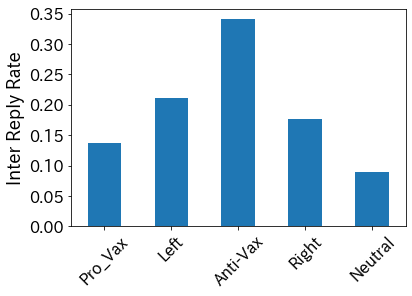

In [49]:
pd.DataFrame(dict_inner_inter_reply).T.divide( pd.DataFrame(dict_inner_inter_reply).T.sum(axis=1), axis=0)["Inter Reply"].plot(kind="bar")
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.ylabel("Inter Reply Rate", size=18)
# plt.savefig("figures/inter_reply_rate_en.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

In [50]:
df_reply_.divide(df_reply_.sum(axis=1), axis=0) * 100

,Pro_Vax,Left,Anti-Vax,Right,Neutral
Pro_Vax,86.340264,2.928683,4.896043,1.453163,4.381847
Left,4.102564,78.871795,0.974359,8.000000,8.051282
Anti-Vax,4.732071,2.585977,65.929086,8.011197,18.741669
Right,1.794872,2.435897,7.307692,82.307692,6.153846
Neutral,1.915240,3.911980,1.202119,1.854116,91.116544


In [51]:
df_reply__ = df_reply_.copy()
for i in selected_clusters:
    df_reply__.loc[i,i]= 0
df_reply__

,Pro_Vax,Left,Anti-Vax,Right,Neutral
Pro_Vax,0,131,219,65,196
Left,80,0,19,156,157
Anti-Vax,355,194,0,601,1406
Right,14,19,57,0,48
Neutral,94,192,59,91,0


In [52]:
df_reply__.divide(df_reply__.sum(axis=1), axis=0) * 100

,Pro_Vax,Left,Anti-Vax,Right,Neutral
Pro_Vax,0.000000,21.440262,35.842881,10.638298,32.078560
Left,19.417476,0.000000,4.611650,37.864078,38.106796
Anti-Vax,13.888889,7.589984,0.000000,23.513302,55.007825
Right,10.144928,13.768116,41.304348,0.000000,34.782609
Neutral,21.559633,44.036697,13.532110,20.871560,0.000000


In [55]:
for i in selected_clusters:
    if i != "Anti-Vax":
        continue
    for k in [j for j in selected_clusters if j != i]:
        print(i, k)

        x2, p, dof, expected = sp.stats.chi2_contingency(
            np.array(
                [
                    [
                        df_reply__.loc[i, k],
                        df_reply__.loc[[j for j in selected_clusters if j not in [i, k]], k].sum()
                    ],
                    [
                        df_reply__.loc[i, [j for j in selected_clusters if j not in [i, k]]].sum(), 
                        df_reply__.loc[[j for j in selected_clusters if j not in [i, k]], [j for j in selected_clusters if j not in [k]]].sum().sum()
                    ]
                ]
            )
        )




        if p < 0.05:
            print("significant")
        else:
            print("not significant")
        print("chi square %(x2)s" %locals() )
        print("prob %(p)s" %locals() )
        print("dof %(dof)s" %locals() )
        print( expected )

Anti-Vax Pro_Vax
significant
chi square 14.301243237069128
prob 0.0001557619714235687
dof 1
[[ 391.84302654  151.15697346]
 [2164.15697346  834.84302654]]
Anti-Vax Left
significant
chi square 296.6984356090699
prob 1.726172216979446e-66
dof 1
[[ 366.21651965  169.78348035]
 [2189.78348035 1015.21651965]]
Anti-Vax Right
not significant
chi square 2.2761908619740354
prob 0.1313741800195752
dof 1
[[ 581.22739726  331.77260274]
 [1974.77260274 1127.22739726]]
Anti-Vax Neutral
significant
chi square 133.07918746722353
prob 8.687650146053454e-31
dof 1
[[1242.58595642  564.41404358]
 [1313.41404358  596.58595642]]


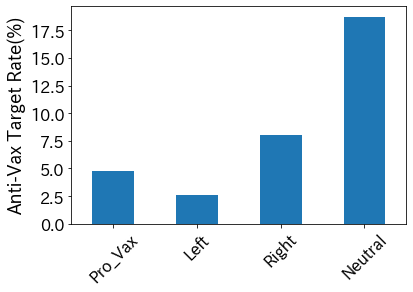

In [56]:
(df_reply_.divide(df_reply_.sum(axis=1), axis=0) * 100).loc["Anti-Vax", [j for j in selected_clusters if j != "Anti-Vax"]].plot(kind="bar")
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.ylabel("Anti-Vax Target Rate(%)", size=18)
# plt.savefig("figures/antivax_target_rate_en.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

In [57]:
df_reply = tmp_df[tmp_df["in_reply_to_screen_name"].notnull()]
tmp_followers_dict = tmp_df.sort_values("user_followers_count").\
    drop_duplicates("user_screen_name", keep="last")
tmp_followers_dict = dict(zip(list(tmp_followers_dict["user_screen_name"]), list(tmp_followers_dict["user_followers_count"])))
df_reply["in_reply_to_screen_name_follower_num"] = df_reply["in_reply_to_screen_name"].swifter.apply(lambda x: tmp_followers_dict[x] if x in tmp_followers_dict else None )
df_reply = df_reply[df_reply["in_reply_to_screen_name_follower_num"].notnull()]

Pandas Apply:   0%|          | 0/293946 [00:00<?, ?it/s]

<ipython-input-57-a01857fcf329>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reply["in_reply_to_screen_name_follower_num"] = df_reply["in_reply_to_screen_name"].swifter.apply(lambda x: tmp_followers_dict[x] if x in tmp_followers_dict else None )


In [58]:
c = 'Anti-Vax'

In [59]:
tmp_cluster1 = tmp_tmp_df[tmp_tmp_df["modularity_class"] == c]
tmp_cluster2 = tmp_tmp_df[tmp_tmp_df["modularity_class"].isin([i for i in selected_clusters if i != c])]

In [60]:
a = df_reply[
        (df_reply["user_screen_name"].isin(tmp_cluster1["Label"]))&(df_reply["in_reply_to_screen_name"].isin(tmp_cluster2["Label"]))
]#[["in_reply_to_screen_name", "in_reply_to_screen_name_follower_num"]].sort_values("in_reply_to_screen_name_follower_num", ascending=False)

In [61]:
# a.to_csv("interclusterreply_from_antivaxxers.csv")

In [62]:
for i in a.drop_duplicates(["in_reply_to_screen_name"]).iterrows():
    print(i[1]["in_reply_to_screen_name"], i[1]["in_reply_to_screen_name_follower_num"])

seanhannity 4592338.0
JohnTitor33621 15118.0
DrEricDing 375482.0
JackPosobiec 1264011.0
CBSNews 7931337.0
marklevinshow 2855821.0
AFP 1956681.0
Reuters 22841580.0
thehill 4066752.0
Surgeon_General 899836.0
cletus1969 3889.0
charliekirk11 1716232.0
markoftheD 20377.0
glennbeck 1406188.0
reubing 39730.0
WhiteHouse 26084706.0
ShinderSuzan 1186.0
piersmorgan 7698536.0
PileOfGoop 2855.0
chipfranklin 174869.0
GOPLeader 1225829.0
DrPanMD 16322.0
ABC 16284625.0
latimes 3764603.0
VeritasEver 4219.0
DailyMailUK 506171.0
AndrewYang 1786780.0
TheKidKidDoc 3488.0
HislopMD 8338.0
jeremyfaust 68291.0
alfonslopeztena 185767.0
NetworksManager 107430.0
ksbyron 4223.0
democracynow 782791.0
GavinNewsom 1975735.0
JudgeJeanine 2563485.0
AmerAcadPeds 102643.0
CDCDirector 220897.0
CDCFlu 892034.0
Jim_Jordan 2006622.0
jennyrachelpal 29815.0
Alyssa_Milano 3761566.0
ScottGottliebMD 448071.0
KillAuDeepState 54835.0
10DowningStreet 5858549.0
Public_Citizen 381177.0
RachelAlter007 2557.0
jennfranconews 111196.0
NYC

Mike_Fabricant 39527.0
Streakyblue1951 965.0
T21Jan 677.0
amyklobuchar 1344476.0
KrutikaKuppalli 22465.0
lewis_goodall 200157.0
FullFact 178677.0
kevinault 1961.0
BBCWalesNews 127031.0
NewYorker 8982628.0
ENirenberg 3134.0
MirrorPolitics 86761.0
uksciencechief 155156.0
bbc5live 674852.0
healthdpt 30415.0
ConversationUK 137121.0
UKGovScotland 26026.0
IHME_UW 53913.0
MichaelRosenYes 220808.0
BBCHughPym 90123.0
MirrorTech 16744.0
beisgovuk 190304.0
Ben_Everitt 6339.0
June4th 4592.0
GBNews24_7 8888.0
hendopolis 90986.0
RichardEngel 434868.0
TODAYshow 4297442.0
RedCollie1 13044.0
epidatum 174.0
newsmax 901636.0
Reuters_Health 241990.0
CBSLA 251465.0
heather_venter 5886.0
apoorva_nyc 37334.0
YahooNews 1112800.0
eNCA 2552717.0
EdMorrissey 67003.0
AnnalisaBurgos 2721.0
Dr_Mike_Stevens 4157.0
petemuntean 6144.0
lopezgovlaw 16176.0
WalterKorfmach1 208.0
FedEx 310648.0
Libertea2012 51052.0
DrZweliMkhize 516395.0
CityAM 66299.0
nowthisnews 2732397.0
TonyBurnetti 892.0
SylvesterTurner 140869.0
KGWN

In [64]:
tmptmp_data = []
for c in selected_clusters:
    tmp_cluster1 = tmp_tmp_df[tmp_tmp_df["modularity_class"] == c]
    tmp_cluster2 = tmp_tmp_df[tmp_tmp_df["modularity_class"].isin([i for i in selected_clusters if i != c])]
    source_follower_counts = df_reply[
        (df_reply["user_screen_name"].isin(tmp_cluster1["Label"]))&(df_reply["in_reply_to_screen_name"].isin(tmp_cluster2["Label"]))
    ].groupby("user_screen_name")["user_followers_count"].mean().mean()
    
    target_follower_counts = df_reply[
        (df_reply["user_screen_name"].isin(tmp_cluster1["Label"]))&(df_reply["in_reply_to_screen_name"].isin(tmp_cluster2["Label"]))
    ].groupby("user_screen_name")["in_reply_to_screen_name_follower_num"].mean().median()
    tmptmp_data.append([
        source_follower_counts,
        target_follower_counts,
        target_follower_counts/source_follower_counts
    ])

In [65]:
pd.options.display.float_format = '{:.2f}'.format
inter_reply_followers = pd.DataFrame(
    index = selected_clusters,
    columns = ["Source", "Target", "Target/Source"],
    data=tmptmp_data
)

inter_reply_followers

,Source,Target,Target/Source
Pro_Vax,9167.64,234687.00,25.60
Left,15026.23,1318926.29,87.77
Anti-Vax,3367.62,455353.00,135.22
Right,21280.44,218730.00,10.28
Neutral,15160.38,258386.25,17.04


In [66]:
tmptmp_data = []
for c in selected_clusters:
    tmp_cluster1 = tmp_tmp_df[tmp_tmp_df["modularity_class"] == c]
    tmp_cluster2 = tmp_tmp_df[tmp_tmp_df["modularity_class"] == c]
    source_follower_counts = df_reply[
        (df_reply["user_screen_name"].isin(tmp_cluster1["Label"]))&(df_reply["in_reply_to_screen_name"].isin(tmp_cluster2["Label"]))
    ].groupby("user_screen_name")["user_followers_count"].mean().mean()
    
    target_follower_counts = df_reply[
        (df_reply["user_screen_name"].isin(tmp_cluster1["Label"]))&(df_reply["in_reply_to_screen_name"].isin(tmp_cluster2["Label"]))
    ].groupby("user_screen_name")["in_reply_to_screen_name_follower_num"].mean().median()
    tmptmp_data.append([
        source_follower_counts,
        target_follower_counts,
        target_follower_counts/source_follower_counts
    ])

In [67]:
inner_reply_followers = pd.DataFrame(
    index = selected_clusters,
    columns = ["Source", "Target", "Target/Source"],
    data=tmptmp_data
)
inner_reply_followers

,Source,Target,Target/Source
Pro_Vax,61280.84,8559.00,0.14
Left,75297.26,84856.00,1.13
Anti-Vax,5103.51,14115.17,2.77
Right,121835.06,92702.25,0.76
Neutral,485946.29,50160.50,0.10


In [68]:
average_followes = {}
for c in selected_clusters:
    print(c)
    t = tmp_df[tmp_df["user_screen_name"].isin(set(tmp_tmp_df[tmp_tmp_df["modularity_class"] == c]["Id"]))]
    print(len(t))
    print(t.drop_duplicates("user_screen_name")["user_followers_count"].median())
    print(t.drop_duplicates("user_screen_name")["user_followers_count"].mean())
    print(t.drop_duplicates("user_screen_name")["user_followers_count"].max())
    
    average_followes[c] = t.drop_duplicates("user_screen_name")["user_followers_count"].median()

Pro_Vax
216130
995.0
21057.45763888889
10426053.0
Left
351436
885.0
23085.21019771072
14064886.0
Anti-Vax
282665
399.5
3851.520117932709
1144599.0
Right
203288
1240.5
33386.021436040435
20909435.0
Neutral
544882
797.0
79799.12106206779
57405979.0


In [71]:
name_cluster = dict(zip(tmp_tmp_df["Label"], tmp_tmp_df["modularity_class"]))

In [79]:
df_reply["source_cluster"] = df_reply["user_screen_name"].map(name_cluster)
df_reply["target_cluster"] = df_reply["in_reply_to_screen_name"].map(name_cluster)

In [80]:
b = {}
for c in selected_clusters:
    print(c)
    print(df_reply[df_reply["source_cluster"] == c].drop_duplicates("user_screen_name")["user_followers_count"].median())
    b[c] = df_reply[df_reply["source_cluster"] == c].drop_duplicates("user_screen_name")["user_followers_count"].median()

b = pd.Series(b, name="Source")

average_followes = pd.Series(average_followes, name="All")

pd.concat([
    inter_reply_followers["Target"],
    #inner_reply_followers["Target"],
    b,
    average_followes
], axis=1)

Pro_Vax
2394.5
Left
3196.0
Anti-Vax
758.0
Right
3831.5
Neutral
3451.0


,Target,Source,All
Pro_Vax,234687.00,2394.50,995.00
Left,1318926.29,3196.00,885.00
Anti-Vax,455353.00,758.00,399.50
Right,218730.00,3831.50,1240.50
Neutral,258386.25,3451.00,797.00


In [81]:
df_reply[
    df_reply["source_cluster"] == "Anti-Vax"
].drop_duplicates("in_reply_to_screen_name").sort_values("in_reply_to_screen_name_follower_num", ascending=False)[
    ["in_reply_to_screen_name", "in_reply_to_screen_name_follower_num"]
].head(10)

,in_reply_to_screen_name,in_reply_to_screen_name_follower_num
1230691275285966848,realDonaldTrump,88941823.00
1249845618610180101,ladygaga,81256721.00
1263557636064083969,cnnbrk,60043587.00
1253557966139207680,CNN,51697722.00
1241077086166626305,BillGates,51479324.00
1275559535009247232,nytimes,48581719.00
1285262421536505857,BBCBreaking,47028093.00
1253337038755000320,POTUS,33104638.00
1257037467959656448,BBCWorld,30353993.00
1230872141198958593,HillaryClinton,28452153.00


In [82]:
df_reply[
    df_reply["source_cluster"] == "Left"
].drop_duplicates("in_reply_to_screen_name").sort_values("in_reply_to_screen_name_follower_num", ascending=False)[
    ["in_reply_to_screen_name", "in_reply_to_screen_name_follower_num"]
].head(10)

,in_reply_to_screen_name,in_reply_to_screen_name_follower_num
1232824820955582464,realDonaldTrump,88941823.00
1329893252313485312,CNN,51697722.00
1254463602909761537,BillGates,51479324.00
1252373417170362371,nytimes,48581719.00
1336315864350683138,BBCWorld,30353993.00
1236719573250068481,WhiteHouse,26084706.00
1252270365612617728,Reuters,22841580.00
1282699367993008130,WSJ,18382369.00
1249622158621454336,TIME,17799100.00
1240648242301468673,washingtonpost,17031946.00


In [83]:
for c in selected_clusters:
    print(c)
    print(df_reply[df_reply["source_cluster"] == c]["user_followers_count"].median())

Pro_Vax
5024.0
Left
5940.0
Anti-Vax
1384.5
Right
5550.0
Neutral
14239.5


In [84]:
for c in selected_clusters:
    print(c)
    print(df_reply[df_reply["target_cluster"] == c]["in_reply_to_screen_name_follower_num"].median())

Pro_Vax
14881.0
Left
375482.0
Anti-Vax
14016.0
Right
866133.0
Neutral
1679368.0


In [85]:
tmptmp_target_cluster_followers = {}
for c1 in selected_clusters:
    tmptmp_target_cluster_followers[c1] = {}
    for c2 in selected_clusters:
        tmp_cluster1 = tmp_tmp_df[tmp_tmp_df["modularity_class"] == c1]
        tmp_cluster2 = tmp_tmp_df[tmp_tmp_df["modularity_class"] == c2]
        tmptmp_target_cluster_followers[c1][c2] = df_reply[
            (df_reply["user_screen_name"].isin(tmp_cluster1["Label"]))&(df_reply["in_reply_to_screen_name"].isin(tmp_cluster2["Label"]))
        ]["in_reply_to_screen_name_follower_num"].median()
        

In [86]:
df_target_cluster_followers = pd.DataFrame(tmptmp_target_cluster_followers).T

In [87]:
df_target_cluster_followers

,Pro_Vax,Left,Anti-Vax,Right,Neutral
Pro_Vax,10374.00,234687.00,1481.00,413820.00,474987.00
Left,111683.50,52454.00,22100.00,2437687.00,1447899.00
Anti-Vax,4157.00,375482.00,6742.00,499008.00,476994.00
Right,2451.00,2813447.00,61696.00,44781.00,1483257.50
Neutral,100741.00,375482.00,11125.00,899836.00,215117.00


In [88]:
tmptmp_target_cluster_followers_up10000 = {}
for c1 in selected_clusters:
    tmptmp_target_cluster_followers_up10000[c1] = {}
    for c2 in selected_clusters:
        tmp_cluster1 = tmp_tmp_df[tmp_tmp_df["modularity_class"] == c1]
        tmp_cluster2 = tmp_tmp_df[tmp_tmp_df["modularity_class"] == c2]
        t = df_reply[
            (df_reply["user_screen_name"].isin(tmp_cluster1["Label"]))&(df_reply["in_reply_to_screen_name"].isin(tmp_cluster2["Label"]))
        ]["in_reply_to_screen_name_follower_num"]
        tmptmp_target_cluster_followers_up10000[c1][c2] = (t >= 10000).sum() / len(t)
        

In [89]:
pd.DataFrame(tmptmp_target_cluster_followers_up10000).T * 100

,Pro_Vax,Left,Anti-Vax,Right,Neutral
Pro_Vax,58.21,90.08,23.29,98.46,93.88
Left,80.00,74.38,68.42,100.00,92.99
Anti-Vax,38.31,92.78,41.79,97.50,94.67
Right,42.86,100.00,73.68,77.10,91.67
Neutral,78.72,94.27,52.54,95.60,80.05


In [90]:
tmptmp_target_cluster_followers_up10000

{'Pro_Vax': {'Pro_Vax': 0.5820818228896945,
  'Left': 0.9007633587786259,
  'Anti-Vax': 0.2328767123287671,
  'Right': 0.9846153846153847,
  'Neutral': 0.9387755102040817},
 'Left': {'Pro_Vax': 0.8,
  'Left': 0.7438231469440832,
  'Anti-Vax': 0.6842105263157895,
  'Right': 1.0,
  'Neutral': 0.9299363057324841},
 'Anti-Vax': {'Pro_Vax': 0.38309859154929576,
  'Left': 0.9278350515463918,
  'Anti-Vax': 0.41791346542660734,
  'Right': 0.9750415973377704,
  'Neutral': 0.9466571834992887},
 'Right': {'Pro_Vax': 0.42857142857142855,
  'Left': 1.0,
  'Anti-Vax': 0.7368421052631579,
  'Right': 0.7710280373831776,
  'Neutral': 0.9166666666666666},
 'Neutral': {'Pro_Vax': 0.7872340425531915,
  'Left': 0.9427083333333334,
  'Anti-Vax': 0.5254237288135594,
  'Right': 0.9560439560439561,
  'Neutral': 0.8005366726296959}}

In [91]:
t = df_reply[
            (df_reply["user_screen_name"].isin(tmp_cluster1["Label"]))&(df_reply["in_reply_to_screen_name"].isin(tmp_cluster2["Label"]))
        ]["in_reply_to_screen_name_follower_num"]

In [92]:
t

1230464380204134401       3573.00
1230535278575734784      24801.00
1230737665932320768     100923.00
1230841392819142657      88665.00
1230903761012436993    6553229.00
                          ...    
1344631138439069696      17772.00
1344637789992837122   17031946.00
1344639782127886336     139270.00
1344655764045111297      48551.00
1344657168943857664    7210752.00
Name: in_reply_to_screen_name_follower_num, Length: 4472, dtype: float64

In [93]:
tmptmp_target_cluster_followers = {}
for c1 in selected_clusters:
    #tmptmp_target_cluster_followers[c1] = {}
    #for c2 in selected_clusters:
    print(c1)
    tmp_cluster1 = tmp_tmp_df[tmp_tmp_df["modularity_class"] == c1]
    #tmp_cluster2 = tmp_tmp_df[tmp_tmp_df["modularity_class"] == c2]
    print(
        df_reply[
            (df_reply["user_screen_name"].isin(tmp_cluster1["Label"]))
        ]["in_reply_to_screen_name"].value_counts().head(10)
    )
        

Pro_Vax
DonnaYoungDC     1033
megtirrell         82
MonicaMalta7       59
syinvesting        41
das_seed           39
newscientist       35
pfizer             34
bamajc7            34
PeterHotez         32
PSuiteNetwork      32
Name: in_reply_to_screen_name, dtype: int64
Left
realDonaldTrump    133
DrEricDing          54
undarkmag           45
DrDenaGrayson       42
atrupar             34
Edourdoo            29
gecko39             27
WTFJHT              25
Laurie_Garrett      24
peopleb4pharma      24
Name: in_reply_to_screen_name, dtype: int64
Anti-Vax
MattHancock        207
realDonaldTrump    159
SkyNews            104
SouledOutWorld      91
LotusOak2           72
ShahzadFaisalMD     72
o_rips              67
simondolan          64
freedomgirl2011     61
top_grafisch        59
Name: in_reply_to_screen_name, dtype: int64
Right
realDonaldTrump    51
starknightz        49
US_FDA             21
NIH                21
DontDregMeBro      14
POTUS              13
mitchellvii        12
Jewhad

In [94]:
tmptmp_target_cluster_followers = {}
for c1 in selected_clusters:
    print(c1)
    tmptmp_target_cluster_followers[c1] = {}
    for c2 in selected_clusters:
        print("to", c2)
        tmp_cluster1 = tmp_tmp_df[tmp_tmp_df["modularity_class"] == c1]
        tmp_cluster2 = tmp_tmp_df[tmp_tmp_df["modularity_class"] == c2]
        print(
            df_reply[
                (df_reply["user_screen_name"].isin(tmp_cluster1["Label"]))&(df_reply["in_reply_to_screen_name"].isin(tmp_cluster2["Label"]))
            ]["in_reply_to_screen_name"].value_counts().head(5)
        )
    print("======")
        

Pro_Vax
to Pro_Vax
DonnaYoungDC    1033
megtirrell        82
MonicaMalta7      59
syinvesting       41
das_seed          39
Name: in_reply_to_screen_name, dtype: int64
to Left
ChelseaClinton    6
Laurie_Garrett    6
DrEricDing        6
JoeBiden          4
ASlavitt          4
Name: in_reply_to_screen_name, dtype: int64
to Anti-Vax
Just4TheCause    25
MacBaird13       18
organicdot       15
BlueLionBlog     12
KayVonPaul       12
Name: in_reply_to_screen_name, dtype: int64
to Right
US_FDA         19
marcorubio      5
CDCDirector     4
SecAzar         4
NIH             3
Name: in_reply_to_screen_name, dtype: int64
to Neutral
senrobportman    19
nytimes          10
UniofOxford       8
Reuters           8
CNN               7
Name: in_reply_to_screen_name, dtype: int64
Left
to Pro_Vax
CDCgov            4
EricTopol         4
HelenBranswell    4
SciencePharmer    4
mattyglesias      3
Name: in_reply_to_screen_name, dtype: int64
to Left
DrEricDing       54
undarkmag        45
DrDenaGrayson    4

In [95]:
df_reply[
            (df_reply["user_screen_name"].isin(tmp_cluster1["Label"]))&(df_reply["in_reply_to_screen_name"].isin(tmp_cluster2["Label"]))
        ]["in_reply_to_screen_name"].value_counts()

ABSCBNNews        347
ANCALERTS         176
BenWinslow        100
arabnews           89
SkyNews            87
                 ... 
NOA_Nigeria         1
ConversationUS      1
ch_zimmer           1
HopeBegley          1
MoscowTimes         1
Name: in_reply_to_screen_name, Length: 913, dtype: int64

## toxicity

In [96]:
# for i, text in tqdm(df_reply["text_no@"].iteritems()):
#     tmp_api_key = xxxxxxxxxxx
    
#     while True:
#         # Generates API client object dynamically based on service name and version.
#         try:
#             service = discovery.build('commentanalyzer', 'v1alpha1', developerKey=tmp_api_key)
#             tmp_dict[i] = get_perspective(text)
#             break
#         except Exception as e:
            
#             if json.loads(e.content)["error"]['code'] == 400:
#                 logger.debug("error code 400 => BREAK")
#                 break
            
#     if len(tmp_dict) % 100 == 0:
#         logger.debug(str("len: ")+ str(len(tmp_dict)))
#         with open('reply_toxic_scores_en_bkp1.pickle', mode='wb') as f:
#             pickle.dump(tmp_dict, f)
            


In [97]:
# with open('reply_toxic_scores_en.pickle', mode='wb') as f:
#     pickle.dump(tmp_dict, f)

In [98]:
with open('../../notebooks/reply_toxic_scores_en.pickle', mode='rb') as f:
    tmp_dict = pickle.load(f)

In [99]:
len(tmp_dict )

243566

In [100]:
df_reply = tmp_df[tmp_df["in_reply_to_screen_name"].notnull()]
tmp_followers_dict = tmp_df.sort_values("user_followers_count").\
    drop_duplicates("user_screen_name", keep="last")
tmp_followers_dict = dict(zip(list(tmp_followers_dict["user_screen_name"]), list(tmp_followers_dict["user_followers_count"])))
df_reply["in_reply_to_screen_name_follower_num"] = df_reply["in_reply_to_screen_name"].swifter.apply(lambda x: tmp_followers_dict[x] if x in tmp_followers_dict else None )

Pandas Apply:   0%|          | 0/293946 [00:00<?, ?it/s]

<ipython-input-100-afd10aac3fe6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reply["in_reply_to_screen_name_follower_num"] = df_reply["in_reply_to_screen_name"].swifter.apply(lambda x: tmp_followers_dict[x] if x in tmp_followers_dict else None )


In [101]:
df_reply["text_no@"] = df_reply["text"].apply(lambda x: re.sub("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z0-9_]+)", '', x))
df_reply["text_no@"] = df_reply["text_no@"].apply(lambda x: x.strip(" "))

<ipython-input-101-2084614dfd22>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reply["text_no@"] = df_reply["text"].apply(lambda x: re.sub("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z0-9_]+)", '', x))
<ipython-input-101-2084614dfd22>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reply["text_no@"] = df_reply["text_no@"].apply(lambda x: x.strip(" "))


In [102]:
df_reply['TOXICITY'] = df_reply.progress_apply(lambda x: tmp_dict[x.name]['attributeScores']['TOXICITY']['summaryScore']['value'] \
                                              if x.name in tmp_dict else None, axis=1)

Pandas Apply:   0%|          | 0/293946 [00:00<?, ?it/s]

<ipython-input-102-e8f3aaa3d013>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reply['TOXICITY'] = df_reply.progress_apply(lambda x: tmp_dict[x.name]['attributeScores']['TOXICITY']['summaryScore']['value'] \


In [103]:
df_reply = df_reply[df_reply['TOXICITY'].notnull()]

In [104]:
df_reply.sort_values('TOXICITY')["text"][:5].values

array(['@realdonaldtrump biontech, a german company, developed the covid19 vaccine in partnership with pfizer.',
       '@damopelham @scottmorrisonmp hydroxychloroquine is not claimed to be a vaccine, but a therapy used in early stages of covid19.',
       '@2of sage is also fairly confident of vaccine availability in first quarter of 2021.',
       '@timmarkatos torn between “coronavirus vaccine” and “transcontinental high-speed rail network”.',
       '@cernovich next, schumer announces, until vaccine is produced, hydroxychloroquine should be available to the market for covid19 treatment.'],
      dtype=object)

In [105]:
df_reply.sort_values('TOXICITY')["text"][-5:].values

array(['@ticketmaster wants a negative #covid19 or a vaccine? fuck your concerts. i’ll never go again. i hope you assholes… ',
       '@secazar make the vaccine free u rat fucking bastard #coronavirus',
       '@taylorrmarshall fuck this #coronavirusvaccine wtf is this shit #covid19',
       '@marcorubio is a fucking asshole #covidvaccine  line jumper . #tytlive he downplays #covid19  and sits there with a… ',
       '@billgates fuck your vaccines shove that shit up your ass. #covid19 #anonymous'],
      dtype=object)

In [106]:
name_cluster = dict(zip(tmp_tmp_df["Label"], tmp_tmp_df["modularity_class"]))

df_reply["source_cluster"] = df_reply["user_screen_name"].map(name_cluster)

df_reply["target_cluster"] = df_reply["in_reply_to_screen_name"].map(name_cluster)

df_reply["text_no@_len"] = df_reply["text_no@"].apply(lambda x: len(x.split()))

In [110]:
df_reply_ = df_reply[
    df_reply["source_cluster"].isin(selected_clusters)&df_reply["target_cluster"].isin(selected_clusters)&(df_reply["text_no@_len"]>1)
]

In [111]:
df_reply_.shape

(8344, 32)

In [112]:
print(pairwise_tukeyhsd(df_reply_[df_reply_["source_cluster"] != df_reply_["target_cluster"]]["TOXICITY"], 
                 df_reply_[df_reply_["source_cluster"] != df_reply_["target_cluster"]]["source_cluster"])
     )

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2 meandiff p-adj   lower   upper  reject
-------------------------------------------------------
Anti-Vax    Left  -0.0153   0.36 -0.0381  0.0076  False
Anti-Vax Neutral  -0.0445  0.001 -0.0668 -0.0223   True
Anti-Vax Pro_Vax  -0.0449  0.001 -0.0665 -0.0232   True
Anti-Vax   Right  -0.0041    0.9 -0.0414  0.0333  False
    Left Neutral  -0.0292 0.0524 -0.0587  0.0002  False
    Left Pro_Vax  -0.0296 0.0427 -0.0585 -0.0006   True
    Left   Right   0.0112    0.9 -0.0308  0.0533  False
 Neutral Pro_Vax  -0.0003    0.9 -0.0288  0.0282  False
 Neutral   Right   0.0405 0.0623 -0.0012  0.0822  False
 Pro_Vax   Right   0.0408 0.0556 -0.0006  0.0822  False
-------------------------------------------------------


In [113]:
print(pairwise_tukeyhsd(df_reply_[(df_reply_["source_cluster"] != df_reply_["target_cluster"])&(
df_reply_["text_no@_len"]>1)]["TOXICITY"], 
                 df_reply_[(df_reply_["source_cluster"] != df_reply_["target_cluster"])&(
                 df_reply_["text_no@_len"]>1)]["source_cluster"])
     )

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2 meandiff p-adj   lower   upper  reject
-------------------------------------------------------
Anti-Vax    Left  -0.0153   0.36 -0.0381  0.0076  False
Anti-Vax Neutral  -0.0445  0.001 -0.0668 -0.0223   True
Anti-Vax Pro_Vax  -0.0449  0.001 -0.0665 -0.0232   True
Anti-Vax   Right  -0.0041    0.9 -0.0414  0.0333  False
    Left Neutral  -0.0292 0.0524 -0.0587  0.0002  False
    Left Pro_Vax  -0.0296 0.0427 -0.0585 -0.0006   True
    Left   Right   0.0112    0.9 -0.0308  0.0533  False
 Neutral Pro_Vax  -0.0003    0.9 -0.0288  0.0282  False
 Neutral   Right   0.0405 0.0623 -0.0012  0.0822  False
 Pro_Vax   Right   0.0408 0.0556 -0.0006  0.0822  False
-------------------------------------------------------


In [114]:
tmp_screen_names = tmp_tmp_df[tmp_tmp_df["modularity_class"].isin(selected_clusters)]["Label"].values

len(tmp_screen_names)

tmp_organic_tweets = tmp_df[
    tmp_df["in_reply_to_screen_name"].isnull() & tmp_df["retweeted_status_screen_name"].isnull() & tmp_df["user_screen_name"].isin(tmp_screen_names)
]

tmp_organic_tweets["text_no@"] = tmp_organic_tweets["text"].apply(lambda x: re.sub("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z0-9_]+)", '', x))
tmp_organic_tweets["text_no@"] = tmp_organic_tweets["text_no@"].apply(lambda x: x.strip(" "))
tmp_organic_tweets["nouns"] = tmp_organic_tweets["text_no@"].swifter.apply(lambda x: make_corpus(x))
tmp_organic_tweets["#words"] = tmp_organic_tweets["text_no@"].apply(lambda x: len(x.split()))


<ipython-input-114-010f97da0347>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_organic_tweets["text_no@"] = tmp_organic_tweets["text"].apply(lambda x: re.sub("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z0-9_]+)", '', x))
<ipython-input-114-010f97da0347>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_organic_tweets["text_no@"] = tmp_organic_tweets["text_no@"].apply(lambda x: x.strip(" "))


Pandas Apply:   0%|          | 0/213171 [00:00<?, ?it/s]

<ipython-input-114-010f97da0347>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_organic_tweets["nouns"] = tmp_organic_tweets["text_no@"].swifter.apply(lambda x: make_corpus(x))
<ipython-input-114-010f97da0347>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_organic_tweets["#words"] = tmp_organic_tweets["text_no@"].apply(lambda x: len(x.split()))


In [120]:
tmp_organic_tweets.iloc[0].name

'1230280910047715328'

In [118]:
organic_toxic_scores_en

{'1230280910047715328': {'attributeScores': {'TOXICITY': {'spanScores': [{'begin': 0,
      'end': 103,
      'score': {'value': 0.08252143, 'type': 'PROBABILITY'}}],
    'summaryScore': {'value': 0.08252143, 'type': 'PROBABILITY'}}},
  'languages': ['en'],
  'detectedLanguages': ['en']},
 '1230282878547828739': {'attributeScores': {'TOXICITY': {'spanScores': [{'begin': 0,
      'end': 116,
      'score': {'value': 0.09737328, 'type': 'PROBABILITY'}}],
    'summaryScore': {'value': 0.09737328, 'type': 'PROBABILITY'}}},
  'languages': ['en'],
  'detectedLanguages': ['en']},
 '1230284013958553601': {'attributeScores': {'TOXICITY': {'spanScores': [{'begin': 0,
      'end': 116,
      'score': {'value': 0.096294545, 'type': 'PROBABILITY'}}],
    'summaryScore': {'value': 0.096294545, 'type': 'PROBABILITY'}}},
  'languages': ['en'],
  'detectedLanguages': ['en']},
 '1230290352944435201': {'attributeScores': {'TOXICITY': {'spanScores': [{'begin': 0,
      'end': 85,
      'score': {'value': 

In [123]:
tmp_organic_tweets["text_no@_tokenized"] = tmp_organic_tweets["text_no@"].swifter.apply(lambda x: tknzr.tokenize(x.lower()))

with open('../../notebooks/organic_toxic_scores_en_bkp1.pickle', mode='rb') as f:
    organic_toxic_scores_en = pickle.load(f)

Pandas Apply:   0%|          | 0/213171 [00:00<?, ?it/s]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [124]:
tmp_organic_tweets['TOXICITY'] = tmp_organic_tweets.apply(lambda x: organic_toxic_scores_en[x.name]['attributeScores']['TOXICITY']['summaryScore']['value'] \
                                              if x.name in organic_toxic_scores_en else None, axis=1)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [125]:
tmp_organic_tweets["source_cluster"] = tmp_organic_tweets["user_screen_name"].map(name_cluster)
tmp_organic_tweets["target_cluster"] = tmp_organic_tweets["in_reply_to_screen_name"].map(name_cluster)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [126]:
# toxic organic
tmp_organic_tweets.groupby("source_cluster")['TOXICITY'].median()

source_cluster
Anti-Vax   0.12
Left       0.10
Neutral    0.09
Pro_Vax    0.09
Right      0.11
Name: TOXICITY, dtype: float64

In [127]:
pd.options.display.float_format = '{:.3f}'.format
df_reply_[df_reply_["source_cluster"] != df_reply_["target_cluster"]].groupby("source_cluster")['TOXICITY'].median()

source_cluster
Anti-Vax   0.112
Left       0.104
Neutral    0.087
Pro_Vax    0.092
Right      0.119
Name: TOXICITY, dtype: float64

In [128]:
df_reply_[df_reply_["source_cluster"] == df_reply_["target_cluster"]].groupby("source_cluster")['TOXICITY'].median()

source_cluster
Anti-Vax   0.109
Left       0.109
Neutral    0.091
Pro_Vax    0.090
Right      0.112
Name: TOXICITY, dtype: float64

In [129]:
print(pairwise_tukeyhsd(
    df_reply_[(df_reply_["source_cluster"] != df_reply_["target_cluster"])&(df_reply_["source_cluster"]=="Anti-Vax")]["TOXICITY"], 
    df_reply_[(df_reply_["source_cluster"] != df_reply_["target_cluster"])&(df_reply_["source_cluster"]=="Anti-Vax")]["target_cluster"]
))

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   Left Neutral   0.0089 0.8776 -0.0225 0.0403  False
   Left Pro_Vax  -0.0049    0.9 -0.0459 0.0362  False
   Left   Right   0.0633  0.001  0.0295 0.0971   True
Neutral Pro_Vax  -0.0137 0.6386 -0.0444 0.0169  False
Neutral   Right   0.0544  0.001  0.0345 0.0744   True
Pro_Vax   Right   0.0682  0.001  0.0351 0.1013   True
-----------------------------------------------------


In [130]:
for c, j in enumerate(df_reply_["source_cluster"].unique()):
    for jj in list(df_reply_["source_cluster"].unique())[c:]:
        if j == jj:
            continue
        print(j, jj)
        print(sp.stats.mannwhitneyu(
            df_reply_[df_reply_["source_cluster"] == j]["TOXICITY"], df_reply_[df_reply_["source_cluster"] == jj]["TOXICITY"], alternative='two-sided'
        )
        )

Anti-Vax Left
MannwhitneyuResult(statistic=2244126.0, pvalue=0.30977929258038595)
Anti-Vax Neutral
MannwhitneyuResult(statistic=3380186.5, pvalue=5.230156454055778e-26)
Anti-Vax Pro_Vax
MannwhitneyuResult(statistic=2895990.5, pvalue=1.722677410891364e-21)
Anti-Vax Right
MannwhitneyuResult(statistic=821308.5, pvalue=0.27268798933811433)
Left Neutral
MannwhitneyuResult(statistic=562361.0, pvalue=1.4755622430472302e-11)
Left Pro_Vax
MannwhitneyuResult(statistic=481072.0, pvalue=6.920705551430126e-10)
Left Right
MannwhitneyuResult(statistic=136631.5, pvalue=0.13274698788182387)
Neutral Pro_Vax
MannwhitneyuResult(statistic=521851.5, pvalue=0.6714443132897998)
Neutral Right
MannwhitneyuResult(statistic=142212.0, pvalue=1.1133431458413352e-10)
Pro_Vax Right
MannwhitneyuResult(statistic=123857.5, pvalue=8.725140957678594e-10)


Pro_Vax


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


type
inner    0.090
normal   0.085
outer    0.092
Name: TOXICITY, dtype: float64
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 inner normal  -0.0208  0.001 -0.0298 -0.0117   True
 inner  outer   0.0066 0.4567 -0.0063  0.0195  False
normal  outer   0.0274  0.001  0.0181  0.0366   True
----------------------------------------------------
outer inner
MannwhitneyuResult(statistic=117885.0, pvalue=0.32294144364421273)
outer normal
MannwhitneyuResult(statistic=10896198.5, pvalue=9.557832445202499e-05)
inner normal
MannwhitneyuResult(statistic=11091878.0, pvalue=0.012804294499789858)


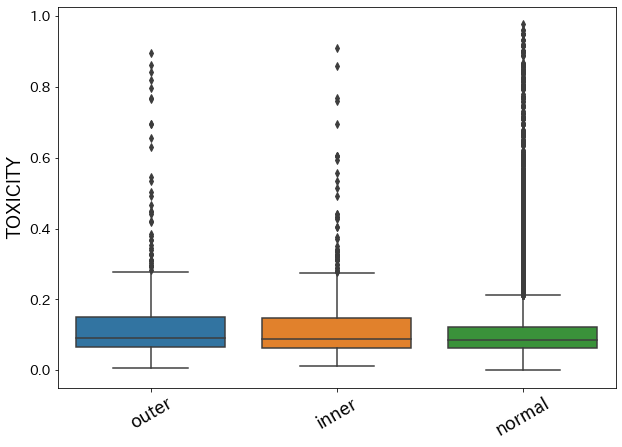

Left


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


type
inner    0.109
normal   0.100
outer    0.104
Name: TOXICITY, dtype: float64
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 inner normal  -0.0547  0.001 -0.0684  -0.041   True
 inner  outer  -0.0272 0.0036  -0.047 -0.0074   True
normal  outer   0.0275  0.001   0.013  0.0419   True
----------------------------------------------------
outer inner
MannwhitneyuResult(statistic=88954.0, pvalue=0.26646111533216643)
outer normal
MannwhitneyuResult(statistic=6059863.0, pvalue=0.02032612006579454)
inner normal
MannwhitneyuResult(statistic=7047697.5, pvalue=5.356755324030957e-05)


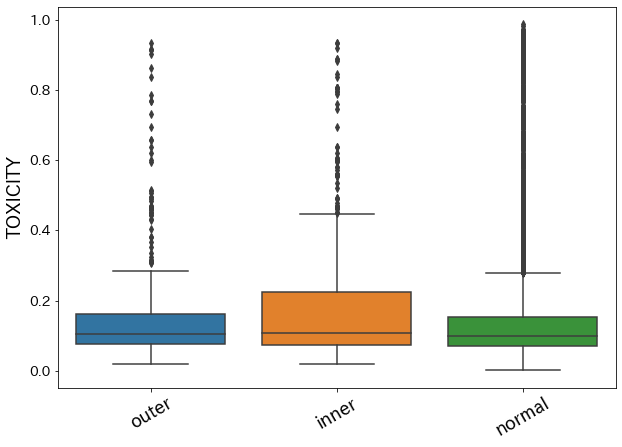

Anti-Vax


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


type
inner    0.109
normal   0.117
outer    0.112
Name: TOXICITY, dtype: float64
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
 inner normal    0.016  0.001 0.0088 0.0231   True
 inner  outer   0.0241  0.001 0.0142 0.0341   True
normal  outer   0.0082 0.0294 0.0006 0.0157   True
--------------------------------------------------
outer inner
MannwhitneyuResult(statistic=3404873.5, pvalue=0.00046166649061004695)
outer normal
MannwhitneyuResult(statistic=32135059.5, pvalue=0.6301725694505621)
inner normal
MannwhitneyuResult(statistic=33820602.0, pvalue=1.9900546515671466e-08)


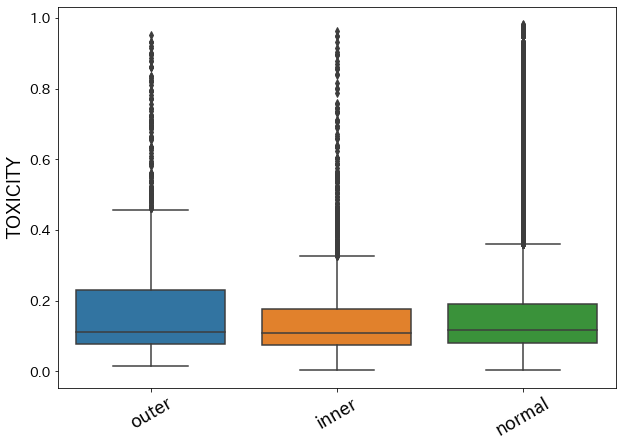

Right


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


type
inner    0.112
normal   0.112
outer    0.119
Name: TOXICITY, dtype: float64
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 inner normal  -0.0248 0.0219 -0.0466 -0.0029   True
 inner  outer  -0.0026    0.9 -0.0365  0.0312  False
normal  outer   0.0221 0.1158  -0.004  0.0482  False
----------------------------------------------------
outer inner
MannwhitneyuResult(statistic=13894.5, pvalue=0.7300961558936739)
outer normal
MannwhitneyuResult(statistic=931390.0, pvalue=0.1354825756125017)
inner normal
MannwhitneyuResult(statistic=1300921.0, pvalue=0.222099664518292)


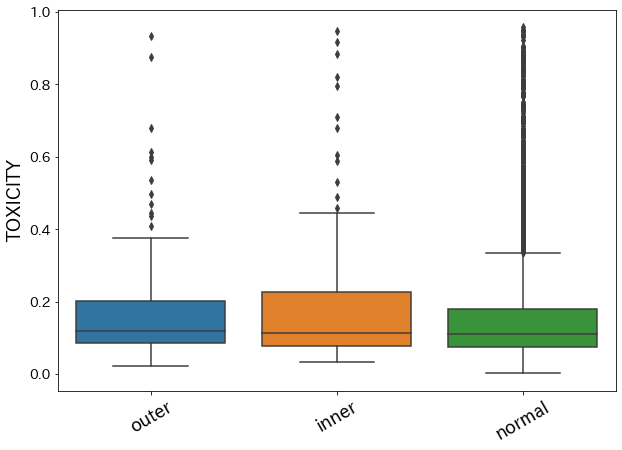

Neutral


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


type
inner    0.091
normal   0.092
outer    0.087
Name: TOXICITY, dtype: float64
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
 inner normal  -0.0156 0.001 -0.0235 -0.0078   True
 inner  outer   0.0032 0.797 -0.0093  0.0157  False
normal  outer   0.0188 0.001  0.0091  0.0286   True
---------------------------------------------------
outer inner
MannwhitneyuResult(statistic=142842.0, pvalue=0.5502315674091527)
outer normal
MannwhitneyuResult(statistic=19816403.5, pvalue=0.3900186165266668)
inner normal
MannwhitneyuResult(statistic=31296632.0, pvalue=0.979959044761328)


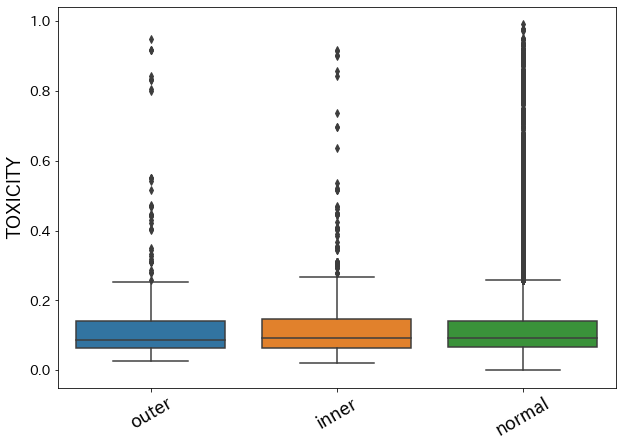

In [131]:
a = []
for i in selected_clusters:
    print(i)
    
    tmp_outer = df_reply_[
        (df_reply_["source_cluster"] != df_reply_["target_cluster"])&(df_reply_["source_cluster"] == i)
    ]
    tmp_outer["type"] = "outer"

    tmp_inner = df_reply_[
        (df_reply_["source_cluster"] == df_reply_["target_cluster"])&(df_reply_["source_cluster"] == i)
    ]
    tmp_inner["type"] = "inner"

    tmp_normal = tmp_organic_tweets[tmp_organic_tweets["source_cluster"] == i]
    tmp_normal["type"] = "normal"

    tmp_concat = pd.concat([
        tmp_outer, tmp_inner, tmp_normal
    ])
    
    tmp_concat = tmp_concat[tmp_concat["TOXICITY"].notnull()]
    
    print(
        tmp_concat.groupby("type")["TOXICITY"].median()
    )
    a.append(tmp_concat.groupby("type")["TOXICITY"].median())
    
    print(pairwise_tukeyhsd(
        tmp_concat["TOXICITY"], 
        tmp_concat["type"]
    ))
    
    for c, j in enumerate(tmp_concat["type"].unique()):
        for jj in list(tmp_concat["type"].unique())[c:]:
            if j == jj:
                continue
            print(j, jj)
            print(sp.stats.mannwhitneyu(
                tmp_concat[tmp_concat["type"] == j]["TOXICITY"], tmp_concat[tmp_concat["type"] == jj]["TOXICITY"], alternative='two-sided'
            )
            )
    
    x = "type"
    y = 'TOXICITY'
    #order = selected_clusters

    plt.figure(figsize=(10,7))
    ax = sns.boxplot(
        x=x,
        y=y, 
        data=tmp_concat,
        #order=selected_clusters
    )
    xticklabels = ax.get_xticklabels()
    ax.set_ylabel(ax.get_ylabel(), size=18)
    ax.set_xlabel("", size=18)
    #ax.set_yticks(ax.get_yticklabels(), size=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xticklabels(xticklabels, rotation = 30, size=18)
    plt.show()

In [132]:
pd.concat(a, axis=1).T

type,inner,normal,outer
TOXICITY,0.090,0.085,0.092
TOXICITY,0.109,0.100,0.104
TOXICITY,0.109,0.117,0.112
TOXICITY,0.112,0.112,0.119
TOXICITY,0.091,0.092,0.087


In [134]:
selected_clusters

['Pro_Vax', 'Left', 'Anti-Vax', 'Right', 'Neutral']

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Pro_Vax v.s. Left: Custom statistical test, P_val:1.000e-03
Pro_Vax v.s. Anti-Vax: Custom statistical test, P_val:1.000e-03
Anti-Vax v.s. Neutral: Custom statistical test, P_val:1.000e-03


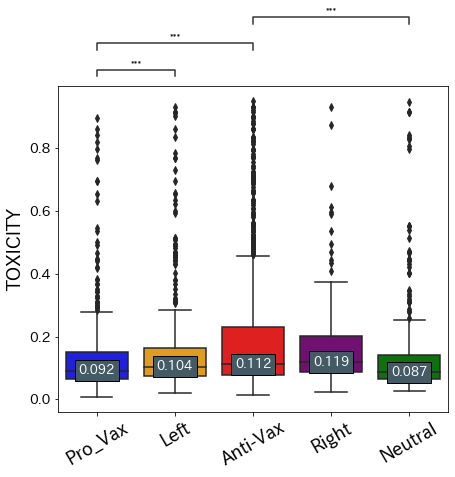

In [135]:
x = "source_cluster"
y = 'TOXICITY'
order = selected_clusters

plt.figure(figsize=(7,6))
ax = sns.boxplot(
    x="source_cluster", 
    y='TOXICITY', 
    data=df_reply_[df_reply_["source_cluster"] != df_reply_["target_cluster"]],
    order=selected_clusters,
    palette=dict(zip(selected_clusters, ["blue", "orange",  "red",  "purple", "green"]))
)
xticklabels = ax.get_xticklabels()
ax.set_ylabel(ax.get_ylabel(), size=18)
ax.set_xlabel("", size=18)
#ax.set_yticks(ax.get_yticklabels(), size=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xticklabels(xticklabels, rotation = 30, size=18)


add_stat_annotation(ax, data=df_reply_, x=x, y=y, order=selected_clusters,
#                     box_pairs=[('Anti-Vax','Pro_Vax'), 
#                                ('Anti-Vax', 'Neutral'), 
#                                ('Pro-Trump', 'Pro_Vax'),
#                                ('Pro-Trump', 'Neutral'),
#                                ('Pro_Vax', 'Anti-Trump'),
#                                ('Anti-Trump', 'Neutral')
#                               ],
#                     perform_stat_test=False, pvalues=[0.001, 0.001, 0.001,  0.001,  0.001,  0.001],
                    box_pairs=[('Anti-Vax','Pro_Vax'), 
                               ('Anti-Vax', 'Neutral'), 
                               ('Pro_Vax', 'Left')
                              ],
                    perform_stat_test=False, pvalues=[0.001, 0.001, 0.001],
                    test=None, text_format='star', loc='outside', verbose=2);

lines = ax.get_lines()
categories = ax.get_xticks()
for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],3) 

    ax.text(
        cat, 
        y, 
        f"{y:.3f}",#f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=13,
        color='white',
        bbox=dict(facecolor='#445A64'))
    

# plt.savefig("figures/toxicity_en.png", format="png", dpi=300, bbox_inches='tight')

In [136]:
from scipy.optimize import curve_fit

In [137]:
a = df_reply_[(df_reply_["source_cluster"]=="Anti-Vax")&(df_reply_["source_cluster"] != df_reply_["target_cluster"])].groupby("in_reply_to_screen_name")["TOXICITY"].median().to_frame()
a["in_reply_to_screen_name_follower_num"] = a.index.map(
    df_reply_.set_index("in_reply_to_screen_name")["in_reply_to_screen_name_follower_num"].to_dict()
)
a["cluster"] = a.index.map(
    df_reply_.set_index("in_reply_to_screen_name")["target_cluster"].to_dict()
)

a["color"] = a["cluster"].map(dict(zip(selected_clusters, ["blue", "orange",  "red",  "purple", "green"])))
a["count"] = a.index.map(
    df_reply_[df_reply_["source_cluster"] != df_reply_["target_cluster"]].value_counts("in_reply_to_screen_name").to_dict()
)

In [138]:
a["count"] 

in_reply_to_screen_name
10DowningStreet    26
1_point_2           1
1a                  2
ABC                27
ABCNewsLive         5
                   ..
washingtonpost     20
welcomehier         1
wxyzdetroit         2
yashar              6
zerohedge          11
Name: count, Length: 647, dtype: int64

In [139]:
from scipy.stats.stats import pearsonr
print(pearsonr(np.log10(a["in_reply_to_screen_name_follower_num"]), a["TOXICITY"]))

(0.020601255734505608, 0.6009326644182974)


Text(36.875, 0.5, 'Median TOXICITY')

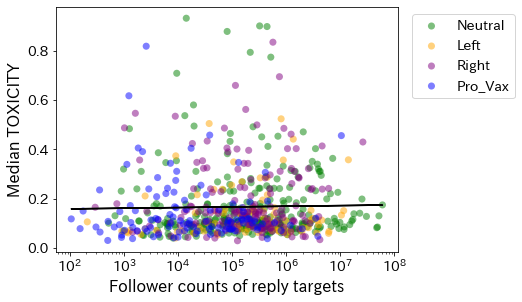

In [141]:
import matplotlib.pyplot
import numpy as np

n = 100
np.random.seed(1)
# x = np.linspace(1,10000,n)
# y = np.zeros(n)
x = a["in_reply_to_screen_name_follower_num"]
y = a["TOXICITY"]
#rand = np.random.randn(n)
#for ii in range(1,n):
#    x[ii] = 10**(float(ii)/10.0)      # Create semi-log linear data
#    y[ii] = rand[ii]*10 + float(ii)   # with some noise in the y values

# plt.scatter(x,y)
fig = plt.figure(figsize=(7,4))
ax=plt.gca() 
#ax.scatter(x,y,c=c,alpha=0.5,edgecolors='none', label=list(a["cluster"]))#, label='data')
#ax.set_yscale('log')
#ax.set_xscale('log')
for i, c_i in enumerate(a["color"].unique()):
    x_i = a[a["color"] == c_i]["in_reply_to_screen_name_follower_num"]
    y_i = a[a["color"] == c_i]["TOXICITY"]
    cluster_i = a[a["color"] == c_i]["cluster"].iloc[0]
    s = a[a["color"] == c_i]["count"]
    ax.scatter(x_i, y_i, label=cluster_i, s=50, alpha=0.5, edgecolors='none', c=c_i)

# for i in tqdm(range(len(x[:10]))):
#     x_i = x.iloc[i]
#     y_i = y.iloc[i]
#     c = a["color"].iloc[i]
#     ax.scatter(x_i, y_i, label=c, s=50, linewidth=0.1, c=c)
ax.legend()

p = np.polyfit(np.log(x), y, 1)
plt.semilogx(x, p[0] * np.log(x) + p[1], 'k-')

plt.xscale('log')
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", fontsize=14)
plt.tight_layout()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Follower counts of reply targets", fontsize=16)
plt.ylabel("Median TOXICITY", fontsize=16)
# plt.savefig("figures/toxicity_byusers_median_en.png", format="png", dpi=300, bbox_inches='tight')

In [142]:
a = df_reply_[(df_reply_["source_cluster"]=="Anti-Vax")&(df_reply_["source_cluster"] != df_reply_["target_cluster"])].groupby("in_reply_to_screen_name")["TOXICITY"].max().to_frame()
a["in_reply_to_screen_name_follower_num"] = a.index.map(
    df_reply_.set_index("in_reply_to_screen_name")["in_reply_to_screen_name_follower_num"].to_dict()
)
a["cluster"] = a.index.map(
    df_reply_.set_index("in_reply_to_screen_name")["target_cluster"].to_dict()
)

a["color"] = a["cluster"].map(dict(zip(selected_clusters, ["blue", "orange",  "red",  "purple", "green"])))

In [143]:
from scipy.stats.stats import pearsonr
print(pearsonr(a["in_reply_to_screen_name_follower_num"], a["TOXICITY"]))

(0.19807858176065535, 3.7936555447036455e-07)


Text(36.875, 0.5, 'Max TOXICITY')

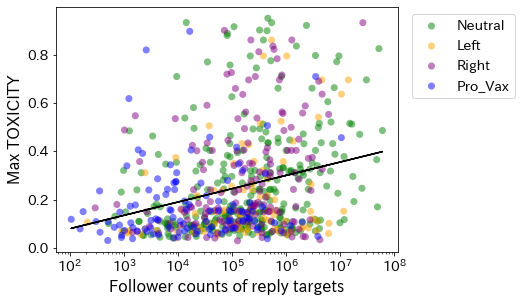

In [144]:
import matplotlib.pyplot
import numpy as np

n = 100
np.random.seed(1)
# x = np.linspace(1,10000,n)
# y = np.zeros(n)
x = a["in_reply_to_screen_name_follower_num"]
y = a["TOXICITY"]
#rand = np.random.randn(n)
#for ii in range(1,n):
#    x[ii] = 10**(float(ii)/10.0)      # Create semi-log linear data
#    y[ii] = rand[ii]*10 + float(ii)   # with some noise in the y values

# plt.scatter(x,y)
fig = plt.figure(figsize=(7,4))
ax=plt.gca() 
#ax.scatter(x,y,c=c,alpha=0.5,edgecolors='none', label=list(a["cluster"]))#, label='data')
#ax.set_yscale('log')
#ax.set_xscale('log')
for i, c_i in enumerate(a["color"].unique()):
    x_i = a[a["color"] == c_i]["in_reply_to_screen_name_follower_num"]
    y_i = a[a["color"] == c_i]["TOXICITY"]
    cluster_i = a[a["color"] == c_i]["cluster"].iloc[0]
    ax.scatter(x_i, y_i, label=cluster_i, s=50, alpha=0.5, edgecolors='none', c=c_i)

# for i in tqdm(range(len(x[:10]))):
#     x_i = x.iloc[i]
#     y_i = y.iloc[i]
#     c = a["color"].iloc[i]
#     ax.scatter(x_i, y_i, label=c, s=50, linewidth=0.1, c=c)
# ax.legend()

p = np.polyfit(np.log(x), y, 1)
plt.semilogx(x, p[0] * np.log(x) + p[1], 'k-')

plt.xscale('log')
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", fontsize=14)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
#           fancybox=False, shadow=False, ncol=5, fontsize=14)
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])
plt.tight_layout()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Follower counts of reply targets", fontsize=16)
plt.ylabel("Max TOXICITY", fontsize=16)
# plt.savefig("figures/toxicity_byusers_max_en.png", format="png", dpi=300, bbox_inches='tight')

Text(36.875, 0.5, 'Max TOXICITY')

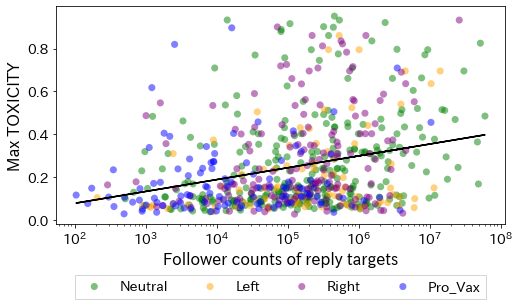

In [145]:
import matplotlib.pyplot
import numpy as np

n = 100
np.random.seed(1)
# x = np.linspace(1,10000,n)
# y = np.zeros(n)
x = a["in_reply_to_screen_name_follower_num"]
y = a["TOXICITY"]
#rand = np.random.randn(n)
#for ii in range(1,n):
#    x[ii] = 10**(float(ii)/10.0)      # Create semi-log linear data
#    y[ii] = rand[ii]*10 + float(ii)   # with some noise in the y values

# plt.scatter(x,y)
fig = plt.figure(figsize=(7,4))
ax=plt.gca() 
#ax.scatter(x,y,c=c,alpha=0.5,edgecolors='none', label=list(a["cluster"]))#, label='data')
#ax.set_yscale('log')
#ax.set_xscale('log')
for i, c_i in enumerate(a["color"].unique()):
    x_i = a[a["color"] == c_i]["in_reply_to_screen_name_follower_num"]
    y_i = a[a["color"] == c_i]["TOXICITY"]
    cluster_i = a[a["color"] == c_i]["cluster"].iloc[0]
    ax.scatter(x_i, y_i, label=cluster_i, s=50, alpha=0.5, edgecolors='none', c=c_i)

# for i in tqdm(range(len(x[:10]))):
#     x_i = x.iloc[i]
#     y_i = y.iloc[i]
#     c = a["color"].iloc[i]
#     ax.scatter(x_i, y_i, label=c, s=50, linewidth=0.1, c=c)
# ax.legend()

p = np.polyfit(np.log(x), y, 1)
plt.semilogx(x, p[0] * np.log(x) + p[1], 'k-')

plt.xscale('log')
#plt.legend(bbox_to_anchor=(1.0,1), loc='lower center', fontsize=14)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=False, shadow=False, ncol=5, fontsize=14)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.tight_layout()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Follower counts of reply targets", fontsize=16)
plt.ylabel("Max TOXICITY", fontsize=16)
# plt.savefig("figures/toxicity_byusers_max_en.png", format="png", dpi=300, bbox_inches='tight')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Right v.s. Neutral: Custom statistical test, P_val:1.000e-03
Left v.s. Right: Custom statistical test, P_val:1.000e-03
Pro_Vax v.s. Right: Custom statistical test, P_val:1.000e-03


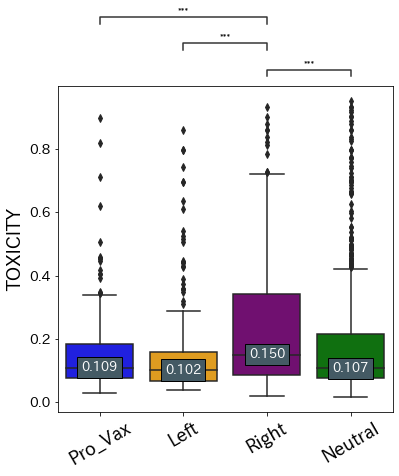

In [149]:
x = "target_cluster"
y = 'TOXICITY'
order = [i for i in selected_clusters if i!="Anti-Vax"]

plt.figure(figsize=(6,6))
ax = sns.boxplot(
    x=x, 
    y='TOXICITY', 
    data=df_reply_[(df_reply_["source_cluster"] != df_reply_["target_cluster"])&(df_reply_["source_cluster"]=="Anti-Vax")],
    order=[i for i in selected_clusters if i!="Anti-Vax"],
    palette=dict(zip(selected_clusters, ["blue", "orange",  "red",  "purple", "green"]))
)
xticklabels = ax.get_xticklabels()
ax.set_ylabel(ax.get_ylabel(), size=18)
ax.set_xlabel("", size=18)
#ax.set_yticks(ax.get_yticklabels(), size=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xticklabels(xticklabels, rotation = 30, size=18)


add_stat_annotation(ax, data=df_reply_[(df_reply_["source_cluster"] != df_reply_["target_cluster"])&(df_reply_["source_cluster"]=="Anti-Vax")], 
                    x=x, y=y, 
                    order=[i for i in selected_clusters if i!="Anti-Vax"],
                    box_pairs=[
                               ('Right', 'Pro_Vax'),
                               ('Right', 'Neutral'),
                               ('Right', 'Left')
                              ],
                    perform_stat_test=False, pvalues=[0.001, 0.001, 0.001],

                    test=None, text_format='star', loc='outside', verbose=2);

lines = ax.get_lines()
categories = ax.get_xticks()
for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],3) 

    ax.text(
        cat, 
        y, 
        f"{y:.3f}",#f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=13,
        color='white',
        bbox=dict(facecolor='#445A64'))
    

# plt.savefig("figures/toxicity_target_en.png", format="png", dpi=300, bbox_inches='tight')

## Emotions

In [150]:
df_reply_["text_no@_tokenized"] = df_reply_["text_no@"].swifter.apply(lambda x: tknzr.tokenize(x.lower()))

Pandas Apply:   0%|          | 0/8344 [00:00<?, ?it/s]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [151]:
df_reply_["#words"] = df_reply_["text_no@_tokenized"].map(len)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [153]:
import liwc
parse, category_names = liwc.load_token_parser('../../input/LIWC2015 Dictionary - Internal.dic')


tmp_liwc = df_reply_["text_no@_tokenized"].swifter.apply(lambda x: 
    pd.Series([category for token in x for category in parse(token)]).value_counts()
)

tmp_liwc = tmp_liwc.fillna(0)

df_reply_ = pd.concat([
    df_reply_, tmp_liwc
], axis=1)

df_reply_ = df_reply_.loc[:,~df_reply_.columns.duplicated()]
df_reply_  = df_reply_.fillna(0)

df_reply_["Qmark"] = df_reply_["text_no@_tokenized"].apply(lambda x:  x.count("?"))

Pandas Apply:   0%|          | 0/8344 [00:00<?, ?it/s]

In [154]:
df_dic_brm = pd.read_csv("../../input/BRM-emot-submit.csv")

arousal_median = df_dic_brm["A.Mean.Sum"].median()
valence_median = df_dic_brm["V.Mean.Sum"].median()
dict_arousal = df_dic_brm.set_index("Word")["A.Mean.Sum"].to_dict()
dict_valence = df_dic_brm.set_index("Word")["V.Mean.Sum"].to_dict()

def get_arousal(x):
    tmp_x = [dict_arousal[i] for i in x if i in dict_arousal if dict_arousal[i] >= arousal_median]
    return len(tmp_x), np.array(tmp_x).mean()

tmp_arousal = df_reply_["text_no@_tokenized"].swifter.apply(lambda x: pd.Series(
    get_arousal(x)
))

tmp_arousal.columns = ["arouse_word_num", "arouse_mean"]

def get_valence(x):
    tmp_x = [dict_valence[i] for i in x if i in dict_valence if dict_valence[i] >= valence_median]
    return len(tmp_x), np.array(tmp_x).mean()

tmp_valence = df_reply_["text_no@_tokenized"].swifter.apply(lambda x: pd.Series(
    get_valence(x)
))

tmp_valence.columns = ["valence_word_num", "valence_mean"]

df_reply_ = pd.concat([
    df_reply_, tmp_arousal, tmp_valence
], axis=1)

Pandas Apply:   0%|          | 0/8344 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8344 [00:00<?, ?it/s]

In [155]:
def tmp_tests(df_, column_):
    display.display(
        df_[df_["source_cluster"] != df_["target_cluster"]].groupby("source_cluster")[column_].describe().T
    )
    display.display(
        df_[
            df_["source_cluster"] != df_["target_cluster"]
        ].pivot_table(values=column_, index="source_cluster", columns="target_cluster", aggfunc='mean')
    )
    
#     tmp_test_result = pairwise_tukeyhsd(
#         df_[df_["source_cluster"] != df_["target_cluster"]][column_], 
#         df_[df_["source_cluster"] != df_["target_cluster"]]["source_cluster"]
#     )

    tmp_result_dict = {}
    num_ = []
    for c, i in enumerate(['Anti-Vax', 'Pro_Vax', 'Left', 'Right', 'Neutral']):#selected_clusters):
        if i not in tmp_result_dict:
            tmp_result_dict[i] = {}
        for cc, j in enumerate(selected_clusters[c:]):
            if i == j:
                continue
            print(i, j)
            a = df_[(df_["source_cluster"] == i)&(df_["target_cluster"] == i)][columns_]
            b = df_[(df_["source_cluster"] == j)&(df_["target_cluster"] == j)][columns_]
            tmp_test_result = sp.stats.mannwhitneyu(
                a,
                b, 
                alternative='two-sided'
            )
            
            # bonferroni
            p_adj = tmp_test_result.pvalue * (len(selected_clusters)*(len(selected_clusters)-1)/2)

            print(tmp_test_result)
            if p_adj < 0.001:
                if a.mean() > b.mean():
                    tmp_test_result_direction =  ">>>"
                elif a.mean() < b.mean():
                    tmp_test_result_direction =  "<<<"
                else:
                    tmp_test_result_direction =  "???"
            elif p_adj < 0.01:
                if a.mean() > b.mean():
                    tmp_test_result_direction =  ">>"
                elif a.mean() < b.mean():
                    tmp_test_result_direction =  "<<"
                else:
                    tmp_test_result_direction =  "??"   
            elif p_adj < 0.05:
                if a.mean() > b.mean():
                    tmp_test_result_direction =  ">"
                elif a.mean() < b.mean():
                    tmp_test_result_direction =  "<"
                else:
                    tmp_test_result_direction =  "?"   
            else:
                tmp_test_result_direction = "-"
            tmp_result_dict[i][j] = tmp_test_result_direction

#     print(
#         tmp_test_result
#     )
    
#     tmp_test_result = pd.DataFrame(tmp_test_result.summary()).T.set_index(0).T
    
    return tmp_result_dict#tmp_test_result

In [156]:
test_results = {}
for columns_ in ["#words", "posemo (Positive Emotions)", "negemo (Negative Emotions)", 'i (I)', 'we (We)', 'you (You)', 'Qmark'] + [ "valence_word_num", "arouse_word_num"]:
    print(columns_)
    test_results[columns_] = tmp_tests(df_reply_, columns_)

#words


source_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
count,2399.000,408.000,435.000,464.000,138.000
mean,18.278,17.887,18.000,18.030,18.457
std,4.217,4.164,4.279,4.419,4.848
min,2.000,5.000,4.000,6.000,3.000
25%,16.000,15.750,16.000,15.000,15.000
50%,19.000,18.000,19.000,18.000,19.000
75%,21.000,20.250,21.000,21.000,22.000
max,32.000,29.000,27.000,33.000,30.000


target_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
source_cluster,,,,,
Anti-Vax,NaN,18.642,18.652,17.265,17.632
Left,17.444,NaN,18.395,17.221,17.756
Neutral,18.379,18.000,NaN,17.277,18.505
Pro_Vax,17.122,18.977,17.607,NaN,18.462
Right,18.439,18.579,19.125,16.071,NaN


Anti-Vax Pro_Vax
MannwhitneyuResult(statistic=662381.0, pvalue=0.8168940006935951)
Anti-Vax Left
MannwhitneyuResult(statistic=509733.0, pvalue=8.99965010807512e-09)
Anti-Vax Right
MannwhitneyuResult(statistic=239982.0, pvalue=0.028797475602705846)
Anti-Vax Neutral
MannwhitneyuResult(statistic=830241.5, pvalue=0.0015433425779271285)
Pro_Vax Left
MannwhitneyuResult(statistic=91989.0, pvalue=2.436050467457843e-06)
Pro_Vax Anti-Vax
MannwhitneyuResult(statistic=653759.0, pvalue=0.8168940006935951)
Pro_Vax Right
MannwhitneyuResult(statistic=43389.0, pvalue=0.037713749066450517)
Pro_Vax Neutral
MannwhitneyuResult(statistic=150132.5, pvalue=0.011230521970715023)
Left Anti-Vax
MannwhitneyuResult(statistic=715083.0, pvalue=8.99965010807512e-09)
Left Right
MannwhitneyuResult(statistic=47768.5, pvalue=0.19589055234787145)
Left Neutral
MannwhitneyuResult(statistic=166439.5, pvalue=0.011825318522553311)
Right Neutral
MannwhitneyuResult(statistic=67523.5, pvalue=0.6429847341969389)
posemo (Positive E

source_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
count,2399.000,408.000,435.000,464.000,138.000
mean,0.291,0.363,0.333,0.366,0.333
std,0.540,0.566,0.544,0.626,0.584
min,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000
75%,1.000,1.000,1.000,1.000,1.000
max,4.000,2.000,3.000,4.000,3.000


target_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
source_cluster,,,,,
Anti-Vax,NaN,0.368,0.286,0.324,0.268
Left,0.111,NaN,0.331,0.416,0.397
Neutral,0.345,0.370,NaN,0.319,0.264
Pro_Vax,0.311,0.465,0.321,NaN,0.369
Right,0.298,0.263,0.438,0.214,NaN


Anti-Vax Pro_Vax
MannwhitneyuResult(statistic=577514.0, pvalue=1.494103444548033e-08)
Anti-Vax Left
MannwhitneyuResult(statistic=558416.5, pvalue=6.737783108268439e-05)
Anti-Vax Right
MannwhitneyuResult(statistic=249732.5, pvalue=0.07829115564269323)
Anti-Vax Neutral
MannwhitneyuResult(statistic=823081.5, pvalue=4.87484820797711e-06)
Pro_Vax Left
MannwhitneyuResult(statistic=115647.0, pvalue=0.26108689681470354)
Pro_Vax Anti-Vax
MannwhitneyuResult(statistic=738626.0, pvalue=1.494103444548033e-08)
Pro_Vax Right
MannwhitneyuResult(statistic=51511.0, pvalue=0.09661582884690965)
Pro_Vax Neutral
MannwhitneyuResult(statistic=170314.0, pvalue=0.20586957913957804)
Left Anti-Vax
MannwhitneyuResult(statistic=666399.5, pvalue=6.737783108268439e-05)
Left Right
MannwhitneyuResult(statistic=46367.0, pvalue=0.42011657909630296)
Left Neutral
MannwhitneyuResult(statistic=153146.5, pvalue=0.9713147097365007)
Right Neutral
MannwhitneyuResult(statistic=64037.0, pvalue=0.4141495547739059)
negemo (Negative 

source_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
count,2399.000,408.000,435.000,464.000,138.000
mean,0.452,0.223,0.154,0.188,0.261
std,0.692,0.502,0.415,0.462,0.544
min,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000
75%,1.000,0.000,0.000,0.000,0.000
max,3.000,2.000,3.000,3.000,3.000


target_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
source_cluster,,,,,
Anti-Vax,NaN,0.451,0.424,0.368,0.546
Left,0.333,NaN,0.204,0.169,0.256
Neutral,0.224,0.104,NaN,0.181,0.187
Pro_Vax,0.203,0.209,0.168,NaN,0.185
Right,0.316,0.211,0.208,0.286,NaN


Anti-Vax Pro_Vax
MannwhitneyuResult(statistic=740895.5, pvalue=4.376288413419626e-09)
Anti-Vax Left
MannwhitneyuResult(statistic=619961.5, pvalue=0.5851445038886216)
Anti-Vax Right
MannwhitneyuResult(statistic=297882.5, pvalue=0.00011749012417952009)
Anti-Vax Neutral
MannwhitneyuResult(statistic=1020692.0, pvalue=1.1364477459462481e-12)
Pro_Vax Left
MannwhitneyuResult(statistic=99605.0, pvalue=2.8011462453198328e-05)
Pro_Vax Anti-Vax
MannwhitneyuResult(statistic=575244.5, pvalue=4.376288413419626e-09)
Pro_Vax Right
MannwhitneyuResult(statistic=48215.0, pvalue=0.9725643716641216)
Pro_Vax Neutral
MannwhitneyuResult(statistic=165582.5, pvalue=0.7270781886329237)
Left Anti-Vax
MannwhitneyuResult(statistic=604854.5, pvalue=0.5851445038886216)
Left Right
MannwhitneyuResult(statistic=49774.0, pvalue=0.0022579013453993546)
Left Neutral
MannwhitneyuResult(statistic=170572.0, pvalue=1.0198809736703875e-06)
Right Neutral
MannwhitneyuResult(statistic=66645.5, pvalue=0.7667394726437684)
i (I)


source_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
count,2399.000,408.000,435.000,464.000,138.000
mean,0.103,0.123,0.159,0.162,0.130
std,0.375,0.414,0.475,0.515,0.449
min,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000
75%,0.000,0.000,0.000,0.000,0.000
max,4.000,4.000,4.000,3.000,3.000


target_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
source_cluster,,,,,
Anti-Vax,NaN,0.109,0.072,0.132,0.161
Left,0.000,NaN,0.172,0.169,0.064
Neutral,0.172,0.198,NaN,0.085,0.143
Pro_Vax,0.230,0.287,0.077,NaN,0.092
Right,0.158,0.105,0.062,0.286,NaN


Anti-Vax Pro_Vax
MannwhitneyuResult(statistic=643937.0, pvalue=0.18639216883629017)
Anti-Vax Left
MannwhitneyuResult(statistic=585194.0, pvalue=0.008664094583238474)
Anti-Vax Right
MannwhitneyuResult(statistic=245807.0, pvalue=0.0038733557543379617)
Anti-Vax Neutral
MannwhitneyuResult(statistic=920796.0, pvalue=0.1166832305311779)
Pro_Vax Left
MannwhitneyuResult(statistic=109128.5, pvalue=0.3238982509238406)
Pro_Vax Anti-Vax
MannwhitneyuResult(statistic=672203.0, pvalue=0.18639216883629017)
Pro_Vax Right
MannwhitneyuResult(statistic=45883.0, pvalue=0.10909856016426041)
Pro_Vax Neutral
MannwhitneyuResult(statistic=171517.5, pvalue=0.024052919364919483)
Left Anti-Vax
MannwhitneyuResult(statistic=639622.0, pvalue=0.008664094583238474)
Left Right
MannwhitneyuResult(statistic=43769.5, pvalue=0.4307026649099346)
Left Neutral
MannwhitneyuResult(statistic=163100.0, pvalue=0.0010556261628815577)
Right Neutral
MannwhitneyuResult(statistic=72239.0, pvalue=0.0004438976066677698)
we (We)


source_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
count,2399.000,408.000,435.000,464.000,138.000
mean,0.114,0.140,0.198,0.129,0.174
std,0.388,0.394,0.448,0.355,0.434
min,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000
75%,0.000,0.000,0.000,0.000,0.000
max,3.000,2.000,4.000,2.000,2.000


target_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
source_cluster,,,,,
Anti-Vax,NaN,0.098,0.126,0.098,0.097
Left,0.167,NaN,0.127,0.182,0.128
Neutral,0.172,0.167,NaN,0.340,0.132
Pro_Vax,0.122,0.202,0.077,NaN,0.154
Right,0.105,0.158,0.229,0.286,NaN


Anti-Vax Pro_Vax
MannwhitneyuResult(statistic=639568.0, pvalue=0.051242492344060496)
Anti-Vax Left
MannwhitneyuResult(statistic=579631.0, pvalue=0.0003993431458298664)
Anti-Vax Right
MannwhitneyuResult(statistic=261883.0, pvalue=0.6335236840902274)
Anti-Vax Neutral
MannwhitneyuResult(statistic=836388.0, pvalue=6.052174779005012e-08)
Pro_Vax Left
MannwhitneyuResult(statistic=108928.0, pvalue=0.2560719998962736)
Pro_Vax Anti-Vax
MannwhitneyuResult(statistic=676572.0, pvalue=0.051242492344060496)
Pro_Vax Right
MannwhitneyuResult(statistic=49142.0, pvalue=0.49820670150120094)
Pro_Vax Neutral
MannwhitneyuResult(statistic=157334.0, pvalue=0.04027510112456297)
Left Anti-Vax
MannwhitneyuResult(statistic=645185.0, pvalue=0.0003993431458298664)
Left Right
MannwhitneyuResult(statistic=46874.0, pvalue=0.13133134271631586)
Left Neutral
MannwhitneyuResult(statistic=150235.0, pvalue=0.414900747964311)
Right Neutral
MannwhitneyuResult(statistic=61997.5, pvalue=0.032381917977703956)
you (You)


source_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
count,2399.000,408.000,435.000,464.000,138.000
mean,0.212,0.179,0.172,0.175,0.261
std,0.537,0.505,0.485,0.448,0.620
min,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000
75%,0.000,0.000,0.000,0.000,0.000
max,4.000,4.000,5.000,2.000,4.000


target_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
source_cluster,,,,,
Anti-Vax,NaN,0.228,0.226,0.245,0.161
Left,0.111,NaN,0.140,0.078,0.276
Neutral,0.138,0.125,NaN,0.181,0.286
Pro_Vax,0.473,0.163,0.082,NaN,0.138
Right,0.193,0.368,0.229,0.500,NaN


Anti-Vax Pro_Vax
MannwhitneyuResult(statistic=650523.0, pvalue=0.4372269338308885)
Anti-Vax Left
MannwhitneyuResult(statistic=624688.0, pvalue=0.17836290731896265)
Anti-Vax Right
MannwhitneyuResult(statistic=262545.0, pvalue=0.7284933244231646)
Anti-Vax Neutral
MannwhitneyuResult(statistic=887023.0, pvalue=0.22961980487982758)
Pro_Vax Left
MannwhitneyuResult(statistic=115261.0, pvalue=0.09730381104778388)
Pro_Vax Anti-Vax
MannwhitneyuResult(statistic=665617.0, pvalue=0.4372269338308885)
Pro_Vax Right
MannwhitneyuResult(statistic=48451.0, pvalue=0.8840398806593455)
Pro_Vax Neutral
MannwhitneyuResult(statistic=163703.0, pvalue=0.8232040734379962)
Left Anti-Vax
MannwhitneyuResult(statistic=600128.0, pvalue=0.17836290731896265)
Left Right
MannwhitneyuResult(statistic=43663.0, pvalue=0.2471351571161743)
Left Neutral
MannwhitneyuResult(statistic=147475.0, pvalue=0.04832041289972937)
Right Neutral
MannwhitneyuResult(statistic=65558.5, pvalue=0.7528491614625806)
Qmark


source_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
count,2399.000,408.000,435.000,464.000,138.000
mean,0.137,0.150,0.110,0.116,0.181
std,0.425,0.524,0.374,0.377,0.423
min,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000
75%,0.000,0.000,0.000,0.000,0.000
max,4.000,6.000,3.000,3.000,2.000


target_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
source_cluster,,,,,
Anti-Vax,NaN,0.155,0.165,0.113,0.075
Left,0.000,NaN,0.185,0.078,0.167
Neutral,0.086,0.125,NaN,0.074,0.132
Pro_Vax,0.122,0.116,0.102,NaN,0.154
Right,0.158,0.158,0.167,0.357,NaN


Anti-Vax Pro_Vax
MannwhitneyuResult(statistic=644222.0, pvalue=0.13481533389690162)
Anti-Vax Left
MannwhitneyuResult(statistic=617132.5, pvalue=0.5864677527201383)
Anti-Vax Right
MannwhitneyuResult(statistic=260049.0, pvalue=0.41354929059004664)
Anti-Vax Neutral
MannwhitneyuResult(statistic=864175.0, pvalue=0.0011963511245983245)
Pro_Vax Left
MannwhitneyuResult(statistic=114933.0, pvalue=0.13051322613191818)
Pro_Vax Anti-Vax
MannwhitneyuResult(statistic=671918.0, pvalue=0.13481533389690162)
Pro_Vax Right
MannwhitneyuResult(statistic=48424.5, pvalue=0.8993378955807392)
Pro_Vax Neutral
MannwhitneyuResult(statistic=161095.5, pvalue=0.2988350688724444)
Left Anti-Vax
MannwhitneyuResult(statistic=607683.5, pvalue=0.5864677527201383)
Left Right
MannwhitneyuResult(statistic=43809.0, pvalue=0.30285701309171664)
Left Neutral
MannwhitneyuResult(statistic=145532.0, pvalue=0.00984209727975322)
Right Neutral
MannwhitneyuResult(statistic=64587.5, pvalue=0.39145495055642743)
valence_word_num


source_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
count,2399.000,408.000,435.000,464.000,138.000
mean,3.116,3.245,3.234,3.119,3.159
std,1.737,1.715,1.681,1.666,1.735
min,0.000,0.000,0.000,0.000,0.000
25%,2.000,2.000,2.000,2.000,2.000
50%,3.000,3.000,3.000,3.000,3.000
75%,4.000,4.000,4.000,4.000,4.000
max,10.000,9.000,8.000,8.000,9.000


target_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
source_cluster,,,,,
Anti-Vax,NaN,3.057,3.340,2.985,2.657
Left,2.389,NaN,3.516,3.390,3.000
Neutral,3.534,3.224,NaN,3.064,3.242
Pro_Vax,2.581,3.574,2.949,NaN,3.338
Right,3.070,3.526,3.312,2.500,NaN


Anti-Vax Pro_Vax
MannwhitneyuResult(statistic=602248.0, pvalue=0.0022831885243877695)
Anti-Vax Left
MannwhitneyuResult(statistic=489919.5, pvalue=3.1100754384548603e-12)
Anti-Vax Right
MannwhitneyuResult(statistic=255908.0, pvalue=0.4332143298183685)
Anti-Vax Neutral
MannwhitneyuResult(statistic=805675.0, pvalue=1.4440482285297572e-05)
Pro_Vax Left
MannwhitneyuResult(statistic=98636.0, pvalue=0.0015403634812892425)
Pro_Vax Anti-Vax
MannwhitneyuResult(statistic=713892.0, pvalue=0.0022831885243877695)
Pro_Vax Right
MannwhitneyuResult(statistic=50587.0, pvalue=0.3156240104741894)
Pro_Vax Neutral
MannwhitneyuResult(statistic=161040.0, pvalue=0.5450008981201344)
Left Anti-Vax
MannwhitneyuResult(statistic=734896.5, pvalue=3.1100754384548603e-12)
Left Right
MannwhitneyuResult(statistic=52163.5, pvalue=0.0008845900913941613)
Left Neutral
MannwhitneyuResult(statistic=167959.5, pvalue=0.004526074192312149)
Right Neutral
MannwhitneyuResult(statistic=61573.0, pvalue=0.13703507433897016)
arouse_wor

source_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
count,2399.000,408.000,435.000,464.000,138.000
mean,2.301,2.194,2.097,2.069,2.225
std,1.349,1.359,1.337,1.243,1.388
min,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,1.000,1.000,1.000
50%,2.000,2.000,2.000,2.000,2.000
75%,3.000,3.000,3.000,3.000,3.000
max,8.000,6.000,7.000,7.000,7.000


target_cluster,Anti-Vax,Left,Neutral,Pro_Vax,Right
source_cluster,,,,,
Anti-Vax,NaN,2.290,2.440,2.196,2.015
Left,2.000,NaN,2.172,2.091,2.288
Neutral,2.000,2.083,NaN,1.947,2.341
Pro_Vax,1.973,2.171,2.020,NaN,2.123
Right,2.105,2.895,2.146,2.071,NaN


Anti-Vax Pro_Vax
MannwhitneyuResult(statistic=682016.0, pvalue=0.18561875806243866)
Anti-Vax Left
MannwhitneyuResult(statistic=525476.0, pvalue=5.771618031822534e-07)
Anti-Vax Right
MannwhitneyuResult(statistic=266732.0, pvalue=0.8433963883658054)
Anti-Vax Neutral
MannwhitneyuResult(statistic=874674.0, pvalue=0.22359481836725126)
Pro_Vax Left
MannwhitneyuResult(statistic=91628.0, pvalue=8.214226247533226e-07)
Pro_Vax Anti-Vax
MannwhitneyuResult(statistic=634124.0, pvalue=0.18561875806243866)
Pro_Vax Right
MannwhitneyuResult(statistic=46842.5, pvalue=0.5307998485422785)
Pro_Vax Neutral
MannwhitneyuResult(statistic=153152.5, pvalue=0.03860834312494296)
Left Anti-Vax
MannwhitneyuResult(statistic=699340.0, pvalue=5.771618031822534e-07)
Left Right
MannwhitneyuResult(statistic=51750.5, pvalue=0.0015073487786684456)
Left Neutral
MannwhitneyuResult(statistic=171013.0, pvalue=0.0005226456756532932)
Right Neutral
MannwhitneyuResult(statistic=63620.5, pvalue=0.40689061201522303)


In [157]:
tmptmp_list_ = []
for column_ in test_results:
    tmptmp_list = []
    pair_list = []
    for group1 in test_results[column_]:
        for group2 in test_results[column_][group1]:
            tmptmp_list.append(
                test_results[column_][group1][group2]
            )
            pair_list.append((group1,group2))
    tmptmp_list_.append(
        pd.Series(tmptmp_list, name=column_)
    )
    
tmptmp_list_.append(
    pd.Series(tmptmp_list, name=column_)
)

In [158]:
df_test_result =pd.concat([
    pd.concat(tmptmp_list_, axis=1),
    pd.DataFrame(pair_list, columns=["group1", "group2"])
], axis=1)
df_test_result

,#words,posemo (Positive Emotions),negemo (Negative Emotions),i (I),we (We),you (You),Qmark,valence_word_num,arouse_word_num,arouse_word_num,group1,group2
0,-,<<<,>>>,-,-,-,-,<,-,-,Anti-Vax,Pro_Vax
1,<<<,<<<,-,-,<<,-,-,<<<,<<<,<<<,Anti-Vax,Left
2,-,-,>>,<,-,-,-,-,-,-,Anti-Vax,Right
3,<,<<<,>>>,-,<<<,-,<,<<<,-,-,Anti-Vax,Neutral
4,<<<,-,<<<,-,-,-,-,<,<<<,<<<,Pro_Vax,Left
5,-,>>>,<<<,-,-,-,-,>,-,-,Pro_Vax,Anti-Vax
6,-,-,-,-,-,-,-,-,-,-,Pro_Vax,Right
7,-,-,-,-,-,-,-,-,-,-,Pro_Vax,Neutral
8,>>>,>>>,-,-,>>,-,-,>>>,>>>,>>>,Left,Anti-Vax
9,-,-,>,-,-,-,-,>>,>,>,Left,Right


In [159]:
df_reply_["urls"] = df_reply_["urls"].map(ast.literal_eval)
df_reply_["urls_wo_tiwtter"] = df_reply_["urls"].apply(lambda x: [i for i in x if "twitter.com" not in i])
df_reply_["urls_flag"] = df_reply_["urls_wo_tiwtter"].map(len) > 0

In [160]:
done_list = []
tmptmptmp_dict = {}
for i in ['Anti-Vax', 'Pro_Vax', 'Left', 'Right', 'Neutral']:
    for j in selected_clusters:
        print(i, j)
        if i == j:
            continue
        if (j, i) in done_list:
            continue
        if i not in tmptmptmp_dict:
            tmptmptmp_dict[i] = {}
        tmp_num1 = df_reply_[(df_reply_["source_cluster"] == i)&(df_reply_["target_cluster"] != i)]["urls_flag"].sum()
        tmp_num_non_1 = len(df_reply_[(df_reply_["source_cluster"] == i)&(df_reply_["target_cluster"] != i)]) - tmp_num1
        tmp_num2 = df_reply_[(df_reply_["source_cluster"] == j)&(df_reply_["target_cluster"] != j)]["urls_flag"].sum()
        tmp_num_non_2 = len(df_reply_[(df_reply_["source_cluster"] == j)&(df_reply_["target_cluster"] != j)]) - tmp_num2
        
        crossed = np.array([
               [tmp_num1, tmp_num_non_1],
                [tmp_num2, tmp_num_non_2]
            ])
        
        x2, p, dof, expected = sp.stats.chi2_contingency(crossed)

        print("chi square %(x2)s" %locals() )
        print("prob %(p)s" %locals() )
        print("dof %(dof)s" %locals() )
        print( crossed )
        print( expected )

        if p < 0.001:
            if (tmp_num1/tmp_num_non_1) > (tmp_num2/tmp_num_non_2):
                if len(df_test_result[
                    (df_test_result["group1"] == i) & (df_test_result["group2"] == j)
                ]) == 1:
                    df_test_result.loc[
                        (df_test_result["group1"] == i) & (df_test_result["group2"] == j)
                    ,"URL"] = ">>>"
                else:
                    df_test_result.loc[
                        (df_test_result["group1"] == j) & (df_test_result["group2"] == i)
                    ,"URL"] = "<<<"
            else:              
                if len(df_test_result[
                    (df_test_result["group1"] == i) & (df_test_result["group2"] == j)
                ]) == 1:
                    df_test_result.loc[
                        (df_test_result["group1"] == i) & (df_test_result["group2"] == j)
                    ,"URL"] = "<<<"
                else:
                    df_test_result.loc[
                        (df_test_result["group1"] == j) & (df_test_result["group2"] == i)
                    ,"URL"] = ">>>"
        elif p < 0.01:
            if (tmp_num1/tmp_num_non_1) > (tmp_num2/tmp_num_non_2):
                if len(df_test_result[
                    (df_test_result["group1"] == i) & (df_test_result["group2"] == j)
                ]) == 1:
                    df_test_result.loc[
                        (df_test_result["group1"] == i) & (df_test_result["group2"] == j)
                    ,"URL"] = ">>"
                else:
                    df_test_result.loc[
                        (df_test_result["group1"] == j) & (df_test_result["group2"] == i)
                    ,"URL"] = "<<"
            else:              
                if len(df_test_result[
                    (df_test_result["group1"] == i) & (df_test_result["group2"] == j)
                ]) == 1:
                    df_test_result.loc[
                        (df_test_result["group1"] == i) & (df_test_result["group2"] == j)
                    , "URL"] = "<<"
                else:
                    df_test_result.loc[
                        (df_test_result["group1"] == j) & (df_test_result["group2"] == i)
                    , "URL"] = ">>"
        elif p < 0.05:
            if (tmp_num1/tmp_num_non_1) > (tmp_num2/tmp_num_non_2):
                if len(df_test_result[
                    (df_test_result["group1"] == i) & (df_test_result["group2"] == j)
                ]) == 1:
                    df_test_result.loc[
                        (df_test_result["group1"] == i) & (df_test_result["group2"] == j)
                    ,"URL"] = ">"
                else:
                    df_test_result.loc[
                        (df_test_result["group1"] == j) & (df_test_result["group2"] == i)
                    ,"URL"] = "<"
            else:              
                if len(df_test_result[
                    (df_test_result["group1"] == i) & (df_test_result["group2"] == j)
                ]) == 1:
                    df_test_result.loc[
                        (df_test_result["group1"] == i) & (df_test_result["group2"] == j)
                    ,"URL"] = "<"
                else:
                    df_test_result.loc[
                        (df_test_result["group1"] == j) & (df_test_result["group2"] == i)
                    ,"URL"] = ">"
        else:
                if len(df_test_result[
                    (df_test_result["group1"] == i) & (df_test_result["group2"] == j)
                ]) == 1:
                    df_test_result.loc[
                        (df_test_result["group1"] == i) & (df_test_result["group2"] == j)
                    ,"URL"] = "-"
                else:
                    df_test_result.loc[
                        (df_test_result["group1"] == j) & (df_test_result["group2"] == i)
                    , "URL"] = "-"
        
        
        if p < 0.05:
            print("significant")
            if crossed[0][0] > expected[0][0]:
                print("observed is larger")
            else:
                pass
        else:
            print("not significant")
        print("\n")
        
        
        done_list.append((i,j))

Anti-Vax Pro_Vax
chi square 0.31262187697638255
prob 0.5760757357843724
dof 1
[[ 219 2180]
 [  38  426]]
[[ 215.3485854 2183.6514146]
 [  41.6514146  422.3485854]]
有意な差がありません


Anti-Vax Left
chi square 0.827272949318852
prob 0.3630622712852939
dof 1
[[ 219 2180]
 [  31  377]]
[[ 213.66227289 2185.33772711]
 [  36.33772711  371.66227289]]
有意な差がありません


Anti-Vax Anti-Vax
Anti-Vax Right
chi square 0.0013199868632779175
prob 0.9710179347030703
dof 1
[[ 219 2180]
 [  13  125]]
[[ 219.38037052 2179.61962948]
 [  12.61962948  125.38037052]]
有意な差がありません


Anti-Vax Neutral
chi square 0.23128974434262187
prob 0.6305691472361561
dof 1
[[ 219 2180]
 [  36  399]]
[[ 215.8592096 2183.1407904]
 [  39.1407904  395.8592096]]
有意な差がありません


Pro_Vax Pro_Vax
Pro_Vax Left
chi square 0.03889429543524313
prob 0.8436582230792214
dof 1
[[ 38 426]
 [ 31 377]]
[[ 36.71559633 427.28440367]
 [ 32.28440367 375.71559633]]
有意な差がありません


Pro_Vax Anti-Vax
Pro_Vax Right
chi square 0.07934792456623911
prob 0.7781830353970123


In [161]:
df_test_result.loc[:, ["group1","group2"]+[j for j in df_test_result.columns if j not in ["group1","group2"]]]

,group1,group2,#words,posemo (Positive Emotions),negemo (Negative Emotions),i (I),we (We),you (You),Qmark,valence_word_num,arouse_word_num,arouse_word_num,arouse_word_num,arouse_word_num,URL
0,Anti-Vax,Pro_Vax,-,<<<,>>>,-,-,-,-,<,-,-,-,-,-
1,Anti-Vax,Left,<<<,<<<,-,-,<<,-,-,<<<,<<<,<<<,<<<,<<<,-
2,Anti-Vax,Right,-,-,>>,<,-,-,-,-,-,-,-,-,-
3,Anti-Vax,Neutral,<,<<<,>>>,-,<<<,-,<,<<<,-,-,-,-,-
4,Pro_Vax,Left,<<<,-,<<<,-,-,-,-,<,<<<,<<<,<<<,<<<,-
5,Pro_Vax,Anti-Vax,-,>>>,<<<,-,-,-,-,>,-,-,-,-,NaN
6,Pro_Vax,Right,-,-,-,-,-,-,-,-,-,-,-,-,-
7,Pro_Vax,Neutral,-,-,-,-,-,-,-,-,-,-,-,-,-
8,Left,Anti-Vax,>>>,>>>,-,-,>>,-,-,>>>,>>>,>>>,>>>,>>>,NaN
9,Left,Right,-,-,>,-,-,-,-,>>,>,>,>,>,-


In [162]:
for columns_ in test_results:
    print("++++++++"*10)
    print(columns_)
    for c, i in enumerate(selected_clusters):
        for cc, j in  enumerate(selected_clusters[c:]):
            if i == j:
                continue
            if i == "Anti-Vax":
                continue
            if j == "Anti-Vax":
                continue
            print(i,j)
            a = df_reply_[(df_reply_["source_cluster"] == "Anti-Vax")&(df_reply_["target_cluster"] == i)][columns_]
            b = df_reply_[(df_reply_["source_cluster"] == "Anti-Vax")&(df_reply_["target_cluster"] == j)][columns_]
            tmp_test_result = sp.stats.mannwhitneyu(
                a,
                b, 
                alternative='two-sided'
            )
            # bonferoni
            print(a.mean(), b.mean())
            print(tmp_test_result.pvalue*6)
            if tmp_test_result.pvalue*6 < 0.05:
                print("SIGNIFICANT")
            print("===")

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#words
Pro_Vax Left
17.264705882352942 18.642487046632123
0.035411517162613385
SIGNIFICANT
===
Pro_Vax Right
17.264705882352942 17.632279534109816
3.571725911540857
===
Pro_Vax Neutral
17.264705882352942 18.651677373304782
0.0001501219275121638
SIGNIFICANT
===
Left Right
18.642487046632123 17.632279534109816
0.021763297388301545
SIGNIFICANT
===
Left Neutral
18.642487046632123 18.651677373304782
4.150838887477654
===
Right Neutral
17.632279534109816 18.651677373304782
1.4171571952179544e-07
SIGNIFICANT
===
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
posemo (Positive Emotions)
Pro_Vax Left
0.3235294117647059 0.36787564766839376
1.9331104627752012
===
Pro_Vax Right
0.3235294117647059 0.26788685524126454
0.611646580576509
===
Pro_Vax Neutral
0.3235294117647059 0.28551034975017847
2.0480696462746266
===
Left Right
0.36787564766839376 0.26788685524126454
0.02680686778933948
S